In [144]:
# Modules
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import tensorflow as tf
import skfuzzy as fuzz
import nibabel as nib
import seaborn as sns
import numpy as np
import itertools
import warnings
import skimage
import imageio
import json
import time
import glob
import cv2
import sys
import os

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Lambda, concatenate
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from skimage import filters, segmentation, color, measure
from medpy.filter.smoothing import anisotropic_diffusion
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
from skimage.transform import resize
from sklearn.utils import shuffle
from miseval import evaluate
from io import BytesIO

# Custom Modules
from morphology.region_growing import region_growing
from morphology.fuzzy_cmeans import fuzzy_cmeans
from morphology.felzenszwalb import felzenszwalb
from morphology.flooding import flooding
from morphology.slic import slic

%matplotlib inline
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Versions of each imported module

import scipy
import matplotlib

print("Available devices:")
print(tf.config.list_physical_devices())

for name, module in globals().items():
    if isinstance(module, type(sys)):
        try:
            print(f"{name}: {module.__version__} - was loaded")
        except AttributeError:
            print(f"{name}: Version not found - was loaded")

Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
__builtin__: Version not found - was loaded
__builtins__: Version not found - was loaded
plt: Version not found - was loaded
ndi: Version not found - was loaded
tf: 2.10.0 - was loaded
fuzz: 0.4.2 - was loaded
nib: 5.1.0 - was loaded
sns: 0.13.0 - was loaded
np: 1.21.6 - was loaded
itertools: Version not found - was loaded
warnings: Version not found - was loaded
skimage: 0.21.0 - was loaded
imageio: 2.32.0 - was loaded
json: 2.0.9 - was loaded
time: Version not found - was loaded
cv2: 4.8.1 - was loaded
sys: Version not found - was loaded
os: Version not found - was loaded
filters: Version not found - was loaded
segmentation: Version not found - was loaded
color: Version not found - was loaded
measure: Version not found - was loaded
scipy: 1.10.1 - was loaded
matplotlib: 3.7.3 - was loaded
glob: Version not found - was loaded


# Exploratory Data Analysis

In [3]:
# Loading all three Sequence Volumes
t1_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-iso08_T1w.nii.gz")
t2_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-T2sel_FLAIR.nii.gz")
t2roi_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-T2sel_FLAIR_roi.nii.gz")

t2_data = t2_vol.get_fdata()
t2roi_data = t2roi_vol.get_fdata()

In [4]:
# T2 Volume Information
t2_hdr = t2_vol.header

print(t2_hdr)
print(t2_vol.shape)

t2_hdr.get_zooms() # voxel size
t2_hdr.get_xyzt_units() # unit of time and space

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 160 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 5. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=3.9e+02;Time=105309.565;phase=1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.052856393
quatern_c       : -0.033188943
quatern_d       : -0.01936007
qoffset_x       : -75.682396
qoffset_y       : -83.82628
qoff

('mm', 'sec')

In [5]:
# T2 Label Volume Information
t2roi_hdr = t2roi_vol.header

print(t2roi_hdr)
print(t2roi_vol.shape)

t2roi_hdr.get_zooms() # voxel size
t2roi_hdr.get_xyzt_units() # unit of time and space

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 160 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : label
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 4.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL4.0'
aux_file        : b'Red-Yellow '
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.052856393
quatern_c       : -0.033188943
quatern_d       : -0.01936007
qoffset_x       : -75.68236
qoffset_y       : -83.826294
qoffset_z       : -13

('mm', 'sec')

In [6]:
# Check Shapes of Planes
print("Sagittal Shape")
print(t2_data[1 :, :,].shape)
print(t2roi_data[1 :, :,].shape)

print("Coronal Shape")
print(t2_data[:, 1 :,].shape)
print(t2roi_data[:, 1 :,].shape)

print("Transverse Shape")
print(t2_data[:, :, 1].shape)
print(t2roi_data[:, :, 1].shape)

Sagittal Shape
(159, 256, 256)
(159, 256, 256)
Coronal Shape
(160, 255, 256)
(160, 255, 256)
Transverse Shape
(160, 256)
(160, 256)


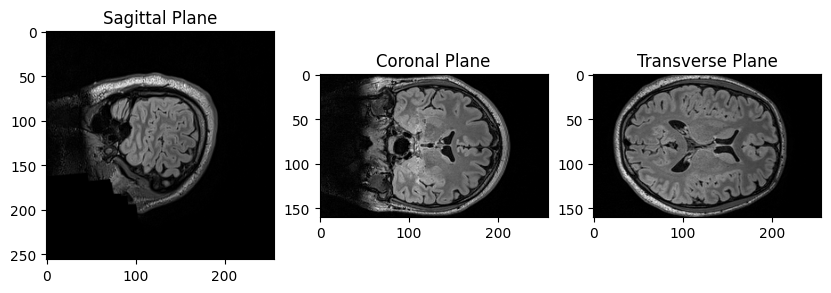

In [7]:
# Print image of all Slices
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(t2_data[135,:,:], cmap="gray"), plt.title("Sagittal Plane")

plt.subplot(1, 3, 2)
plt.imshow(t2_data[:,135,:], cmap="gray"), plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(t2_data[:,:,135], cmap="gray"), plt.title("Transverse Plane")

plt.show()

Text(0.5, 1.0, 'T2 with lesion mask - Slice:135')

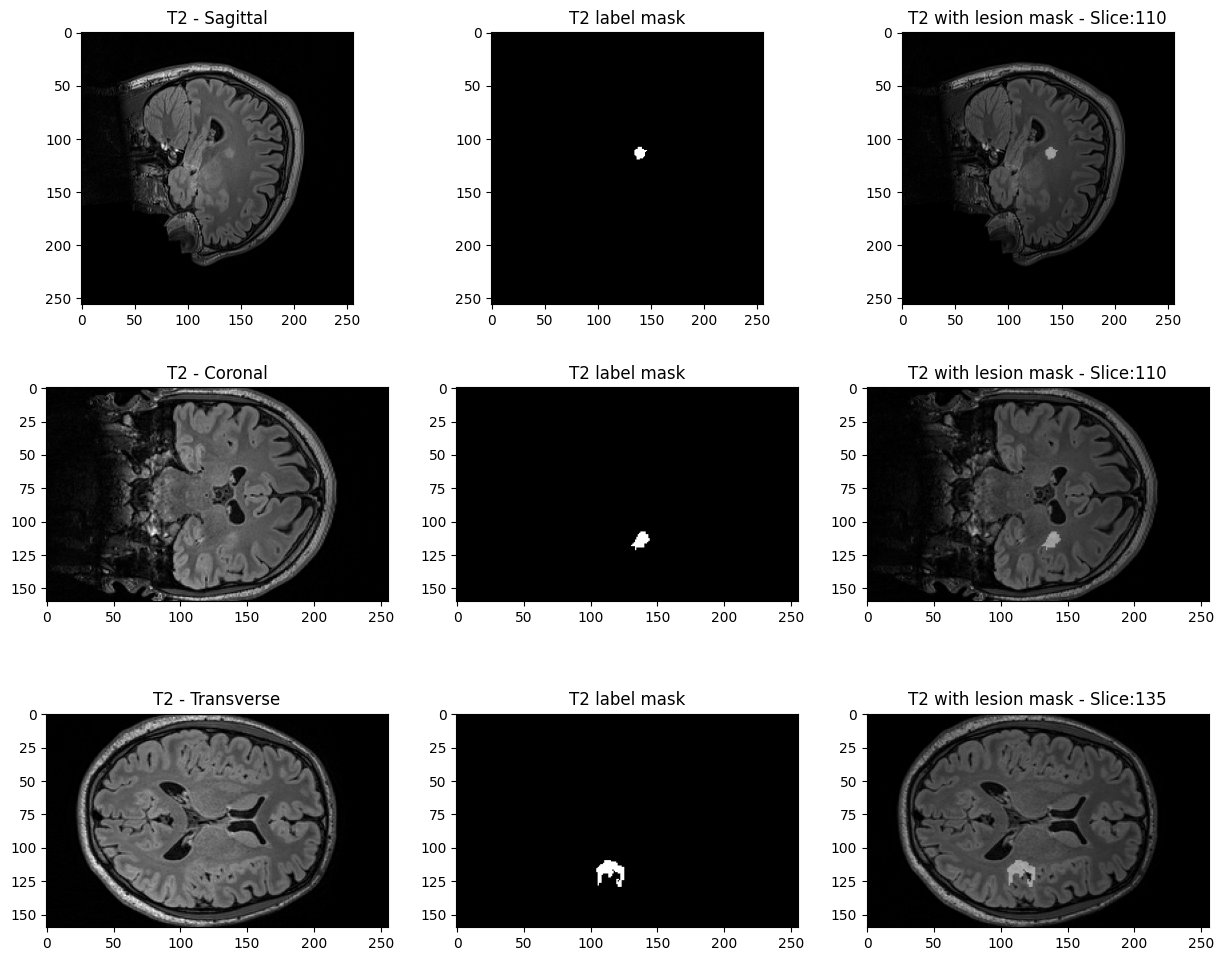

In [8]:
# Plot some slices of all axes of T2 Volume and T2 Label Volume ontop of T2 Volume

plt.figure(figsize=(15, 12))

sliceNum = 110

plt.subplot(3, 3, 1)
plt.imshow(t2_data[sliceNum, :, :], cmap="gray")
plt.title("T2 - Sagittal")

plt.subplot(3, 3, 2)
plt.imshow(t2roi_data[sliceNum, :, :], cmap="gray")
plt.title(f"T2 label mask")

plt.subplot(3, 3, 3)
plt.imshow(t2_data[sliceNum, :, :], cmap="gray")
plt.imshow(t2roi_data[sliceNum, :, :], cmap="gray", alpha=0.3)
plt.title(f"T2 with lesion mask - Slice:{sliceNum}")

sliceNum = 110

plt.subplot(3, 3, 4)
plt.imshow(t2_data[:, sliceNum, :], cmap="gray")
plt.title("T2 - Coronal")

plt.subplot(3, 3, 5)
plt.imshow(t2roi_data[:, sliceNum, :], cmap="gray")
plt.title(f"T2 label mask")

plt.subplot(3, 3, 6)
plt.imshow(t2_data[:, sliceNum, :], cmap="gray")
plt.imshow(t2roi_data[:, sliceNum, :], cmap="gray", alpha=0.3)
plt.title(f"T2 with lesion mask - Slice:{sliceNum}")

sliceNum = 135

plt.subplot(3, 3, 7)
plt.imshow(t2_data[:, :, sliceNum], cmap="gray")
plt.title("T2 - Transverse")

plt.subplot(3, 3, 8)
plt.imshow(t2roi_data[:, :, sliceNum], cmap="gray")
plt.title(f"T2 label mask")

plt.subplot(3, 3, 9)
plt.imshow(t2_data[:, :, sliceNum], cmap="gray")
plt.imshow(t2roi_data[:, :, sliceNum], cmap="gray", alpha=0.3)
plt.title(f"T2 with lesion mask - Slice:{sliceNum}")



In [9]:
# Check percentage of pixels that are lesions

print((np.sum(t2roi_data[110, :, :]) / (256*256) )* 100, "Percent of pixels are lesion")
print((np.sum(t2roi_data[:, 110, :]) / (256*256) )* 100, "Percent of pixels are lesion")
print((np.sum(t2roi_data[:, :, 135]) / (256*256) )* 100, "Percent of pixels are lesion")

0.1434326171875 Percent of pixels are lesion
0.15716552734375 Percent of pixels are lesion
0.33416748046875 Percent of pixels are lesion


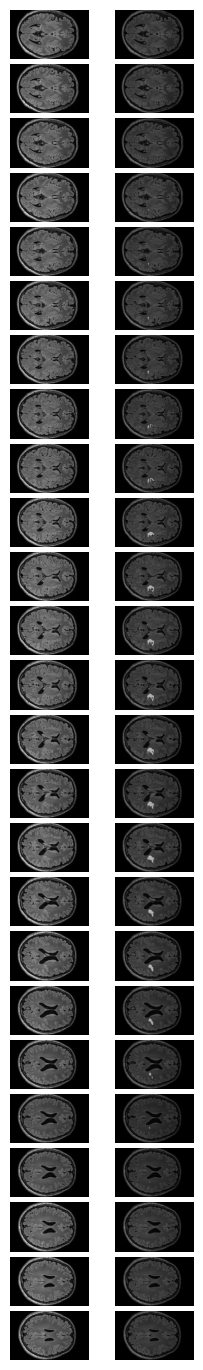

In [10]:
# Create slide view of T2 Volume and T2 Label Volume
plt.figure(figsize=(5, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=.5,
                    top=1,
                    wspace=0.1,
                    hspace=0.1)

for i in range(0, 25):
    plt.subplot(25, 2, i*2+1)
    plt.imshow(t2_data[:, :, 125+i], cmap="gray")
    plt.axis("off")

    plt.subplot(25, 2, i*2+2)
    plt.imshow(t2_data[:, :, 125+i], cmap="gray")
    plt.imshow(t2roi_data[:, :, 125+i], cmap="gray", alpha=0.4)
    plt.axis("off")

In [11]:
# Create gif of T2 Volume and T2 Label Volume
def gif_save(volume, mask, axis, name):
    frames  = []
    for i in range(volume.shape[axis]):
        fig, ax = plt.subplots(figsize=(5, 5))
        
        if axis == 0:
            ax.imshow(volume[i, :, :], cmap="gray")
            ax.imshow(mask[i, :, :], cmap="gray", alpha=0.4)
            ax.set_title(f"{name} - Slice {i}")
            ax.axis("off")
        elif axis == 1:
            ax.imshow(volume[:, i, :], cmap="gray")
            ax.imshow(mask[:, i, :], cmap="gray", alpha=0.4)
            ax.set_title(f"{name} - Slice {i}")
            ax.axis("off")
        elif axis == 2:
            ax.imshow(volume[:, :, i], cmap="gray")
            ax.imshow(mask[:, :, i], cmap="gray", alpha=0.4)
            ax.set_title(f"{name} - Slice {i}")
            ax.axis("off")

        # Create a temporary buffer to capture the plot content
        buf = BytesIO()
        plt.savefig(buf, format="png", dpi=100)  # Save plot to buffer
        buf.seek(0)
        frame = imageio.v2.imread(buf) 
        frames.append(frame)
        
        buf.close()
        plt.close()

    imageio.mimsave(f"images/{name}_mask.gif", frames, duration = 3)


gif_save(t2_data, t2roi_data, 0, "T2-axis1")

gif_save(t2_data, t2roi_data, 1, "T2-axis2")

gif_save(t2_data, t2roi_data, 2, "T2-axis3")

# Morphological Operations

### Pre-processing

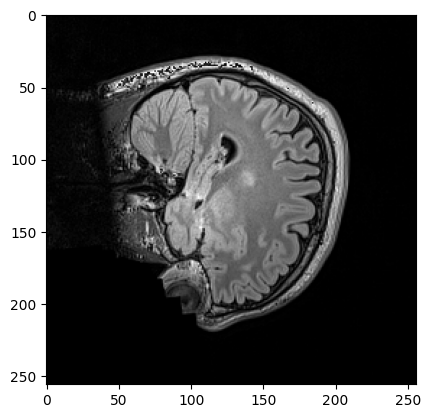

In [12]:
# Manual Image Selector
t2_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-T2sel_FLAIR.nii.gz")
t2roi_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-T2sel_FLAIR_roi.nii.gz")

t2_data = t2_vol.get_fdata()
t2roi_data = t2roi_vol.get_fdata()

def img_selector(axis, sliceNum):
    if axis == 0:
        image = t2_data[sliceNum, :, :]
        mask = t2roi_data[sliceNum, :, :]
    elif axis == 1:
        image = t2_data[:, sliceNum, :]
        mask = t2roi_data[:, sliceNum, :]
    elif axis == 2:
        image = t2_data[:, :, sliceNum]
        mask = t2roi_data[:, :, sliceNum]

    if image.dtype == np.float64:
        image = image.astype(np.uint8)
    if mask.dtype == np.float64:
        mask = mask.astype(np.uint8)
    
    return image, mask

sliceNum = 111
axis = 0

image, mask = img_selector(axis, sliceNum)

plt.imshow(image, cmap="gray")
plt.show()

# print(image.shape)
# print(mask.shape)

#### Seed Points from Label Image

In [13]:
# Finding Seeds

def find_seeds(label_mask):
    # convert float64 to uint8
    label_mask = (label_mask * 255).astype(np.uint8)
    # apply thresholding to make sure its binary
    _, binary_mask = cv2.threshold(label_mask, 127, 255, cv2.THRESH_BINARY)

    # find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    seed_points = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            seed_points.append((cY, cX))

    # # plot seed on label mask
    # plt.imshow(label_mask, cmap="gray")

    # # Loop through your seed points and plot them
    # for (y, x) in seed_points:
    #     plt.scatter(x, y, color="red", s=2) 

    # plt.title(f"Seed Point on Label Mask at {seed_points[0]}")
    # plt.show()

    return seed_points

seed_points = find_seeds(mask)

#### Crop Area

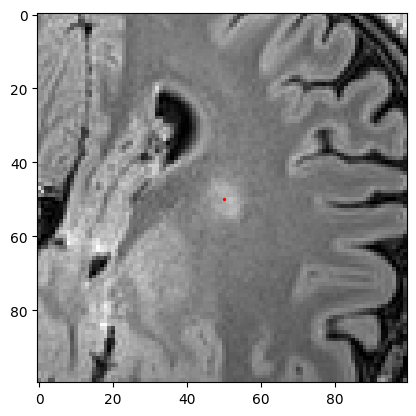

In [14]:
# Function for cropping area around first seed point
crop_dim = 50

def crop_area(image):
    seed_points = find_seeds(mask)
    crop_area = image[seed_points[0][0]- crop_dim: seed_points[0][0] + crop_dim, seed_points[0][1] - crop_dim: seed_points[0][1] + crop_dim]
    return crop_area

adjusted_seed = (crop_dim,) * 2

plt.imshow(crop_area(image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2)
plt.show()

#### Histogram Equalization

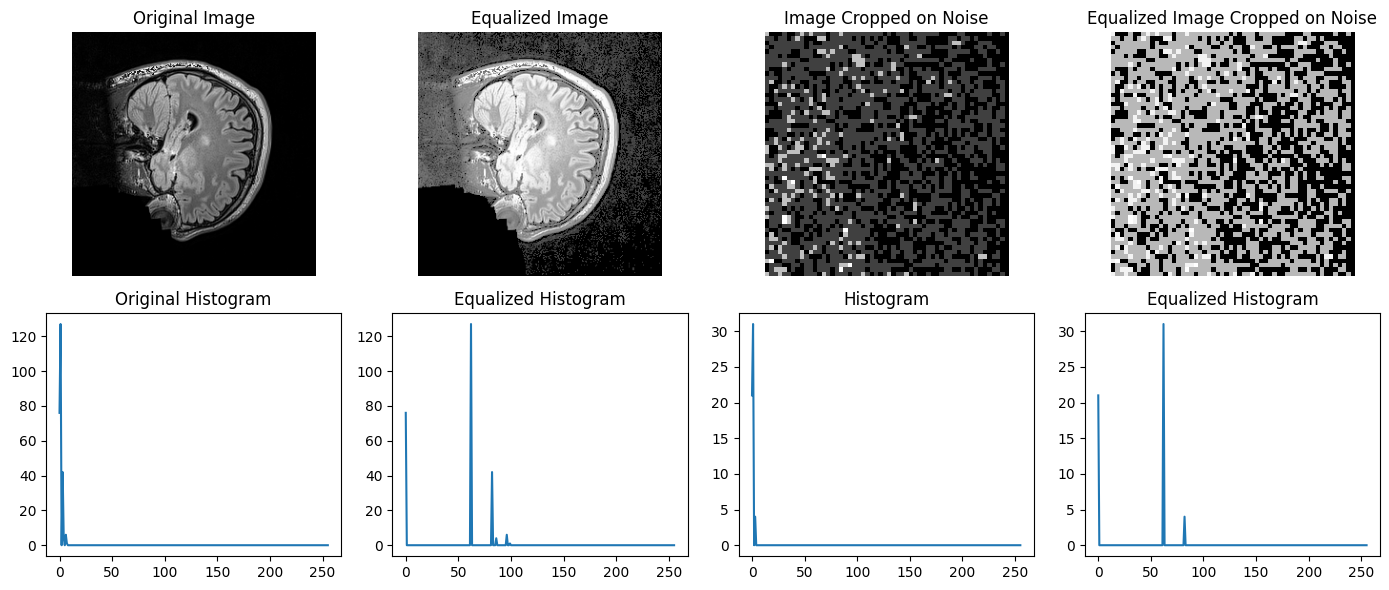

In [15]:
# Histogram Equalization
def histogram_equal(image):
    hist_image = image.copy().astype(np.uint8)

    # Calculate the histogram of the image
    histogram = cv2.calcHist(hist_image, [0], None, [256], [0, 256])
    histogram_cropped = cv2.calcHist(hist_image[:56,200:], [0], None, [256], [0, 256])

    # Perform histogram equalization
    equalized_image = cv2.equalizeHist(hist_image)

    # Calculate the histogram of the equalized image
    equalized_histogram = cv2.calcHist(equalized_image, [0], None, [256], [0, 256])
    equalized_histogram_cropped = cv2.calcHist(equalized_image[:56,200:], [0], None, [256], [0, 256])

    # Plot the original and equalized images and their histograms
    fig, axs = plt.subplots(2, 4, figsize=(14, 6))

    # Original image and histogram
    axs[0, 0].imshow(hist_image, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    axs[1, 0].plot(histogram)
    axs[1, 0].set_title("Original Histogram")

    # Equalized image and histogram
    axs[0, 1].imshow(equalized_image, cmap="gray")
    axs[0, 1].set_title("Equalized Image")
    axs[0, 1].axis("off")

    axs[1, 1].plot(equalized_histogram)
    axs[1, 1].set_title("Equalized Histogram")

    # Equalized image and histogram
    axs[0, 2].imshow(hist_image[:56,200:], cmap="gray")
    axs[0, 2].set_title("Image Cropped on Noise")
    axs[0, 2].axis("off")

    axs[1, 2].plot(histogram_cropped)
    axs[1, 2].set_title("Histogram")

    # Equalized image cropped and histogram
    axs[0, 3].imshow(equalized_image[:56,200:], cmap="gray")
    axs[0, 3].set_title("Equalized Image Cropped on Noise")
    axs[0, 3].axis("off")

    axs[1, 3].plot(equalized_histogram_cropped)
    axs[1, 3].set_title("Equalized Histogram")

    plt.tight_layout()
    plt.show()

equalized_image = histogram_equal(image)

#### Gaussian Filtering

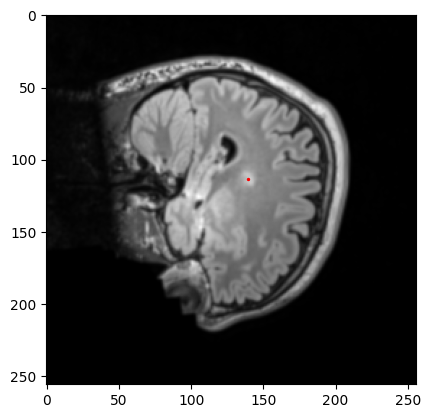

In [16]:
# Gaussian Blur
gaussian_image = filters.gaussian(image, sigma=0.9) * 255

plt.imshow(gaussian_image, cmap="gray")
for (y, x) in seed_points:
    plt.scatter(x, y, color="red", s=2)
plt.show()

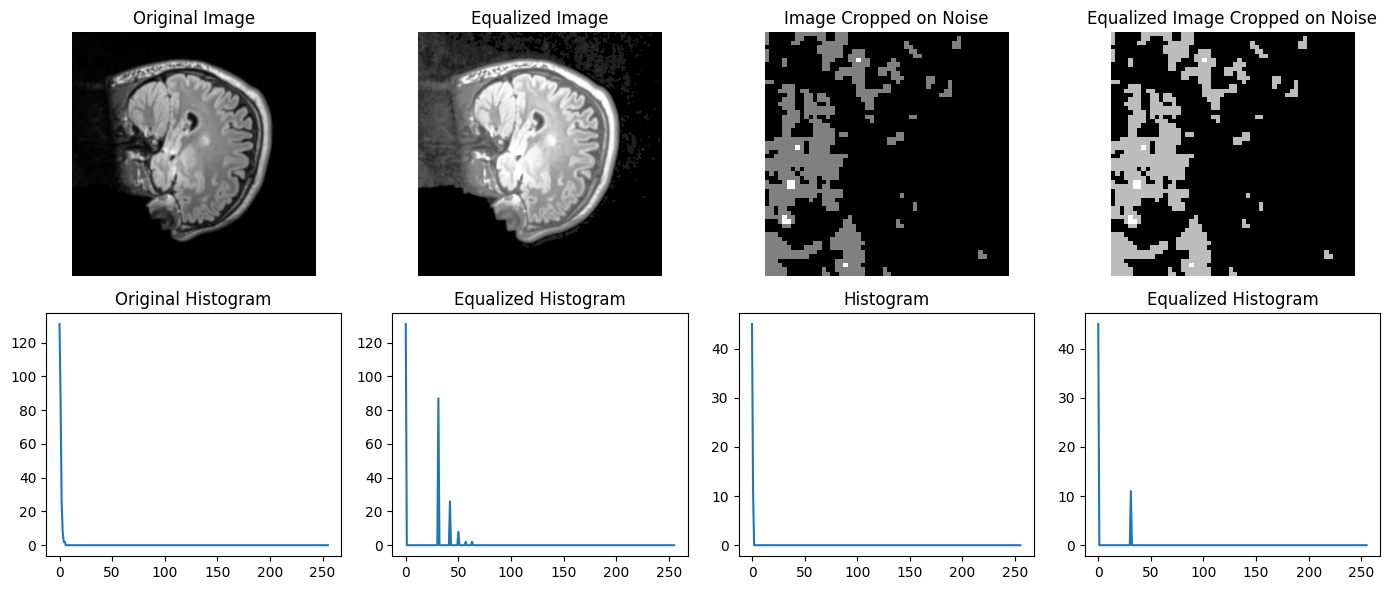

In [17]:
histogram_equal(gaussian_image)

#### Frangi Filter

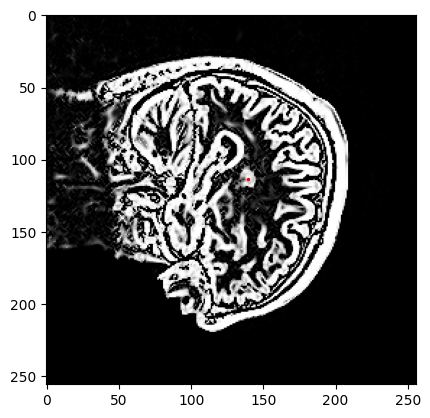

In [18]:
frangi_image = filters.frangi(image, sigmas=(0.5, 2), scale_step=5, beta=1, gamma=0.75, black_ridges=False)

plt.imshow(frangi_image, cmap="gray")
for (y, x) in seed_points:
    plt.scatter(x, y, color="red", s=2)
plt.show()


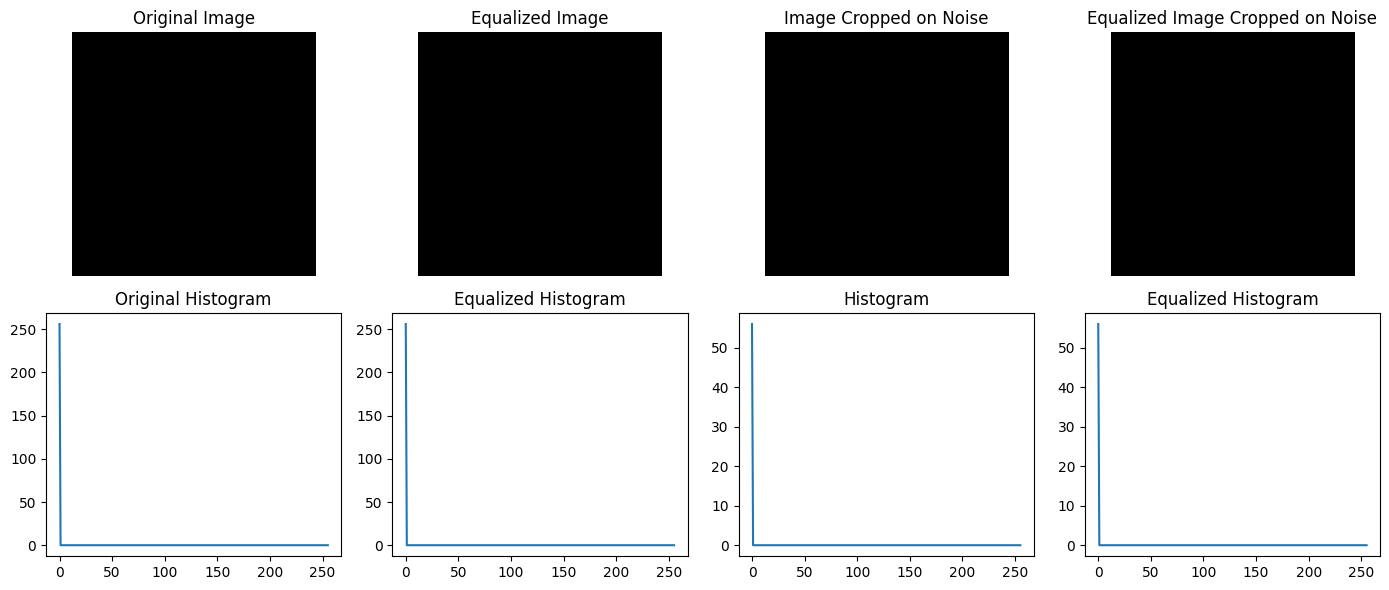

In [19]:
histogram_equal(frangi_image)

#### Anisotropic Diffusion

c:\Users\chris\anaconda3\envs\tf-directml\lib\site-packages\medpy\filter\smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
c:\Users\chris\anaconda3\envs\tf-directml\lib\site-packages\medpy\filter\smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


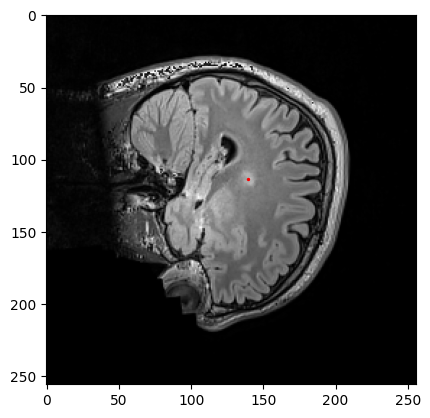

In [20]:
ani_image = anisotropic_diffusion(image, niter=15, kappa=20, gamma=0.01, option=1)

plt.imshow(ani_image, cmap="gray")
for (y, x) in seed_points:
    plt.scatter(x, y, color="red", s=2)
plt.show()

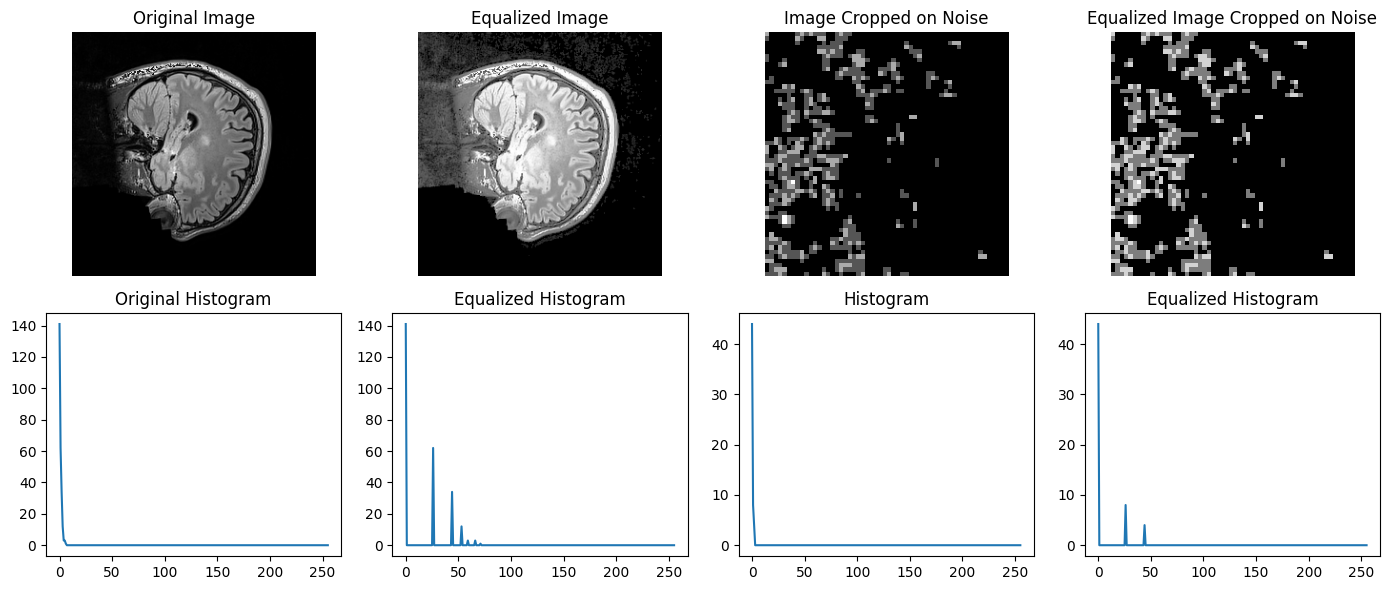

In [21]:
histogram_equal(ani_image)

#### Cropped Comparison of all filters

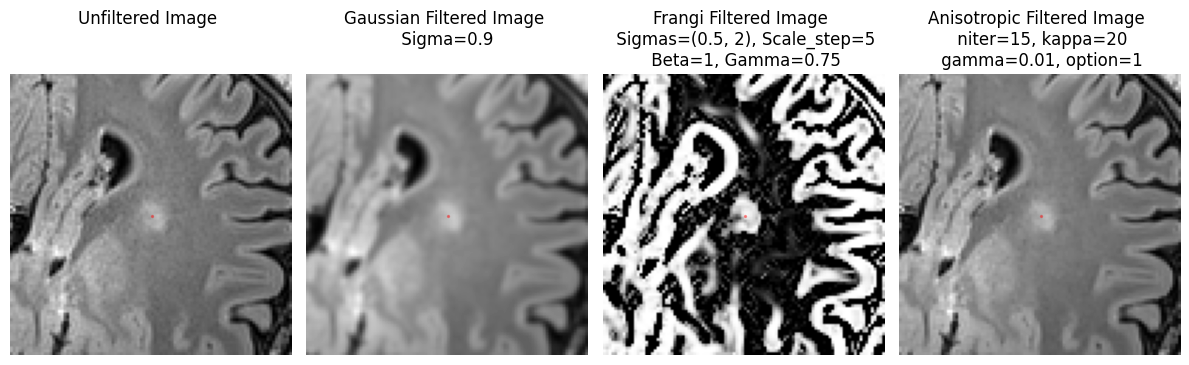

In [22]:
# Unfiltered Image
unfiltered_image = crop_area(image)

# Gaussian Filtered Image
gaussian_filtered_image = crop_area(gaussian_image)

# Frangi Filtered Image
frangi_filtered_image = crop_area(frangi_image)

# Anisotropic Filtered Image
anisotropic_filtered_image = crop_area(ani_image)
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Unfiltered Image
axs[0].imshow(unfiltered_image, cmap="gray")
axs[0].set_title(f"Unfiltered Image \n \n")
axs[0].axis("off")
axs[0].scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2, alpha=0.35)

# Gaussian Filtered Image
axs[1].imshow(gaussian_filtered_image, cmap="gray")
axs[1].set_title(f"Gaussian Filtered Image \n Sigma=0.9 \n")
axs[1].axis("off")
axs[1].scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2, alpha=0.35)

# Frangi Filtered Image
axs[2].imshow(frangi_filtered_image, cmap="gray")
axs[2].set_title(f"Frangi Filtered Image \n Sigmas=(0.5, 2), Scale_step=5\n Beta=1, Gamma=0.75")
axs[2].axis("off")
axs[2].scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2, alpha=0.35)

# Anisotropic Filtered Image
axs[3].imshow(anisotropic_filtered_image, cmap="gray")
axs[3].set_title(f"Anisotropic Filtered Image \n niter=15, kappa=20\n gamma=0.01, option=1")
axs[3].axis("off")
axs[3].scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2, alpha=0.35)

plt.tight_layout()
plt.show()


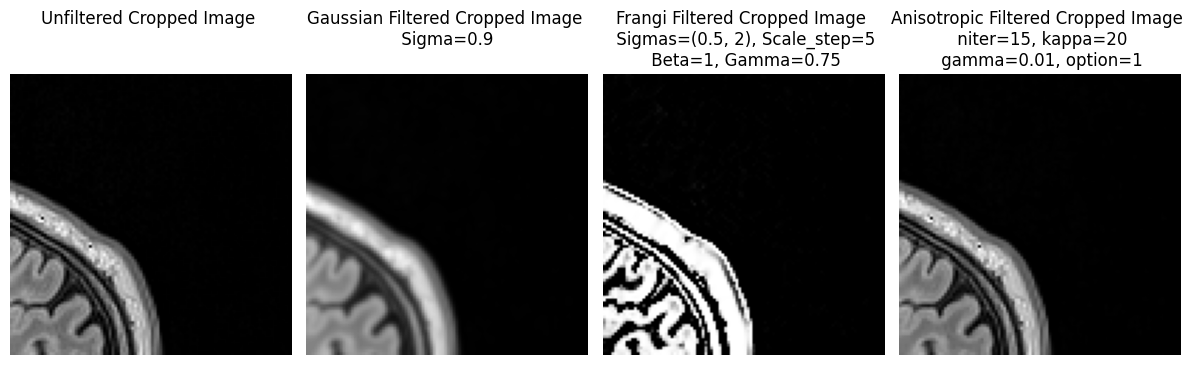

In [23]:
# Crop all images on the top right corner
crop_dim = 100

# Unfiltered Image
unfiltered_cropped = image[:crop_dim, -crop_dim:]

# Gaussian Filtered Image
gaussian_filtered_cropped = gaussian_image[:crop_dim, -crop_dim:]

# Frangi Filtered Image
frangi_filtered_cropped = frangi_image[:crop_dim, -crop_dim:]

# Anisotropic Filtered Image
anisotropic_filtered_cropped = ani_image[:crop_dim, -crop_dim:]

fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Unfiltered Image
axs[0].imshow(unfiltered_cropped, cmap="gray")
axs[0].set_title(f"Unfiltered Cropped Image \n \n")
axs[0].axis("off")

# Gaussian Filtered Image
axs[1].imshow(gaussian_filtered_cropped, cmap="gray")
axs[1].set_title(f"Gaussian Filtered Cropped Image \n Sigma=0.9 \n")
axs[1].axis("off")

# Frangi Filtered Image
axs[2].imshow(frangi_filtered_cropped, cmap="gray")
axs[2].set_title(f"Frangi Filtered Cropped Image \n Sigmas=(0.5, 2), Scale_step=5\n Beta=1, Gamma=0.75")
axs[2].axis("off")

# Anisotropic Filtered Image
axs[3].imshow(anisotropic_filtered_cropped, cmap="gray")
axs[3].set_title(f"Anisotropic Filtered Cropped Image \n niter=15, kappa=20\n gamma=0.01, option=1")
axs[3].axis("off")

plt.tight_layout()
plt.show()


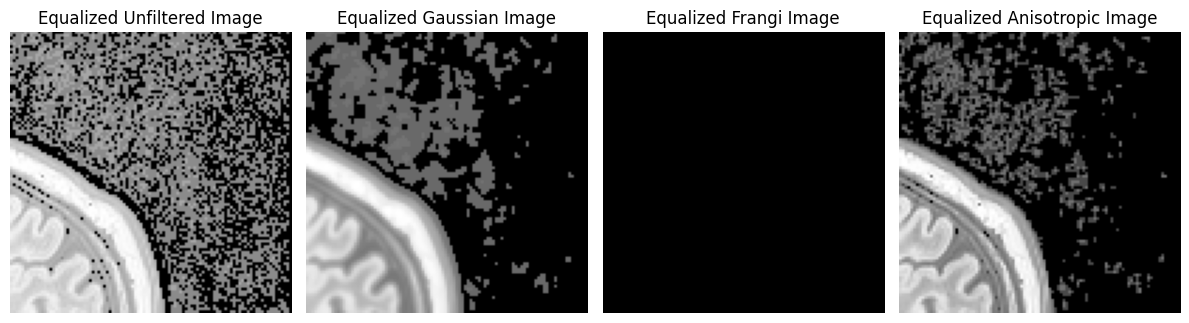

In [24]:
# Histogram Equalization on Cropped Images
equalized_unfiltered_cropped = cv2.equalizeHist(unfiltered_cropped.astype(np.uint8))
equalized_gaussian_filtered_cropped = cv2.equalizeHist(gaussian_filtered_cropped.astype(np.uint8))
equalized_frangi_filtered_cropped = cv2.equalizeHist(frangi_filtered_cropped.astype(np.uint8))
equalized_anisotropic_filtered_cropped = cv2.equalizeHist(anisotropic_filtered_cropped.astype(np.uint8))

fig, axs = plt.subplots(1, 4, figsize=(12, 6))

# Equalized Unfiltered Cropped Image
axs[0].imshow(equalized_unfiltered_cropped, cmap="gray")
axs[0].set_title(f"Equalized Unfiltered Image")
axs[0].axis("off")

# Equalized Gaussian Filtered Cropped Image
axs[1].imshow(equalized_gaussian_filtered_cropped, cmap="gray")
axs[1].set_title(f"Equalized Gaussian Image")
axs[1].axis("off")

# Equalized Frangi Filtered Cropped Image
axs[2].imshow(equalized_frangi_filtered_cropped, cmap="gray")
axs[2].set_title(f"Equalized Frangi Image")
axs[2].axis("off")

# Equalized Anisotropic Filtered Cropped Image
axs[3].imshow(equalized_anisotropic_filtered_cropped, cmap="gray")
axs[3].set_title(f"Equalized Anisotropic Image")
axs[3].axis("off")

plt.tight_layout()
plt.show()


### Performance Evaluation

In [25]:
# Evaluate scores
def eval_print_scores(mask, segment):
    print("Dice Score: ", evaluate(mask, segment, metric="DSC"))
    # print("IoU Score: ", evaluate(mask, segment, metric="IoU"))
    print("Sensitivity Score: ", evaluate(mask, segment, metric="SENS"))
    print("Specificity Score: ", evaluate(mask, segment, metric="SPEC"))
    # print("Precision Score: ", evaluate(mask, segment, metric="PREC"))
    # print("Accuracy Score: ", evaluate(mask, segment, metric="ACC"))
    print("Average Hausdorff Distance: ", evaluate(mask, segment, metric="AHD"))

### Region-Growing

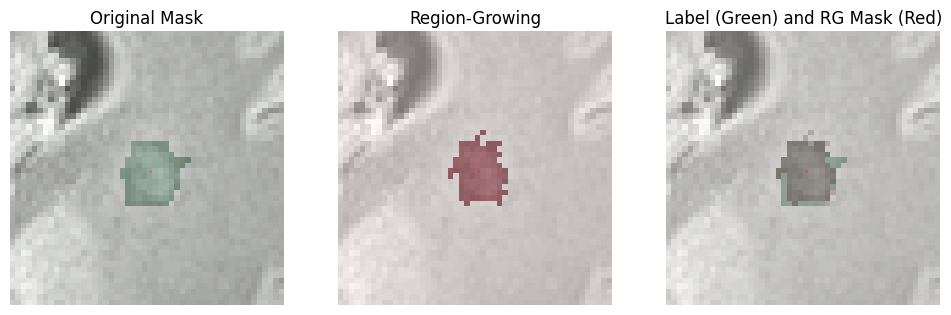

Dice Score:  0.8815165876777251
Sensitivity Score:  0.8230088495575221
Specificity Score:  0.9979053204859657
Average Hausdorff Distance:  2.8284271247461903


In [221]:
def region_growing_single(image, seed, threshold):
    height, width = image.shape
    region = np.zeros_like(image, dtype=np.uint8) 
    points_to_visit = [seed]

    # The mean intensity of the region; starting with the seed intensity
    region_mean = float(image[seed])
    region[seed] = 255

    neighbours = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]

    # Loop until there are no more points to visit
    while points_to_visit:
        y, x = points_to_visit.pop(0)

        # Check the neighbors of the current point
        for dy, dx in neighbours:
            ny, nx = y + dy, x + dx

            # Skip out-of-bounds or already added points
            if nx < 0 or ny < 0 or nx >= height or ny >= width or region[ny, nx] == 255:
                continue

            # Calculate intensity difference
            intensity_diff = abs(int(image[ny, nx]) - region_mean)

            if intensity_diff < threshold:
                region[ny, nx] = 255
                points_to_visit.append((ny, nx))
                # Recalculate the mean intensity of the region
                region_mean = ((region_mean * np.sum(region == 255)) + int(image[ny, nx])) / (np.sum(region == 255) + 1)

    return region


crop_dim = 25
adjusted_seed = (crop_dim,) * 2

segmented_image = region_growing_single(crop_area(image), adjusted_seed, 21) / 255

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(crop_area(image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.3)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(segmented_image, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Region-Growing")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(segmented_image, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and RG Mask (Red)")
plt.axis("off")

plt.show()

eval_print_scores(crop_area(mask), segmented_image)

Anisotropic Diffusion

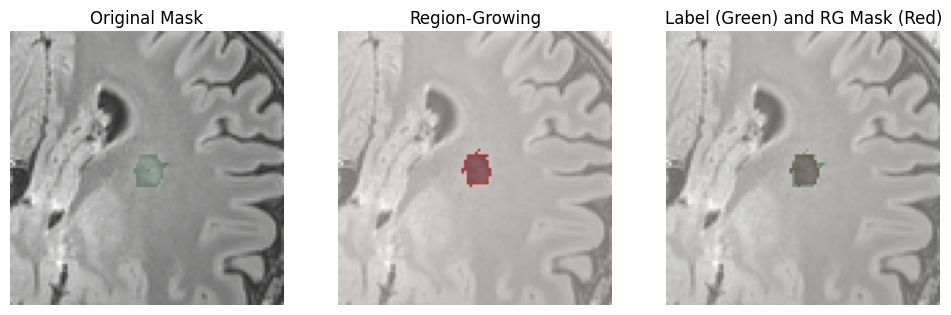

Dice Score:  0.8962264150943396
Sensitivity Score:  0.8407079646017699
Specificity Score:  0.9995954283402447
Average Hausdorff Distance:  2.8284271247461903


In [376]:
segmented_image = region_growing_single(crop_area(ani_image), adjusted_seed, 20.5) / 255

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.2)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.imshow(segmented_image, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Region-Growing")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.imshow(segmented_image, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and RG Mask (Red)")
plt.axis("off")

plt.show()

eval_print_scores(crop_area(mask), segmented_image)

### Flooding

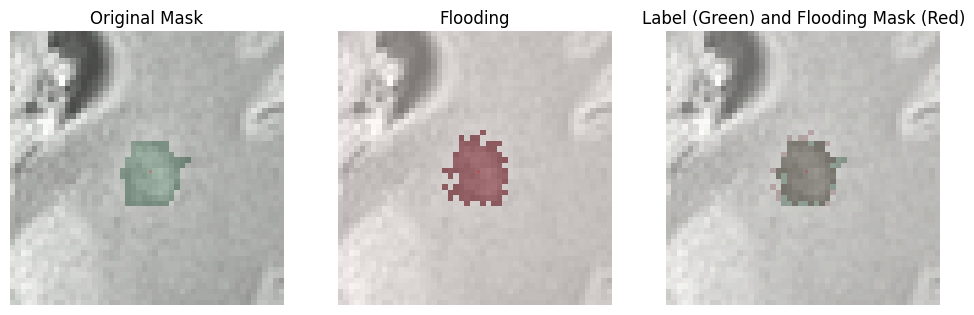

Dice Score:  0.8839285714285714
Sensitivity Score:  0.8761061946902655
Specificity Score:  0.9949727691663176
Average Hausdorff Distance:  2.0


In [222]:
# Flooding Segmentation
segmented_image = segmentation.flood(crop_area(image), adjusted_seed, connectivity=2, tolerance=30)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(crop_area(image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.3)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(segmented_image, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Flooding")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(segmented_image, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and Flooding Mask (Red)")
plt.axis("off")

plt.show()

eval_print_scores(crop_area(mask), segmented_image)

Anisotropic Diffusion

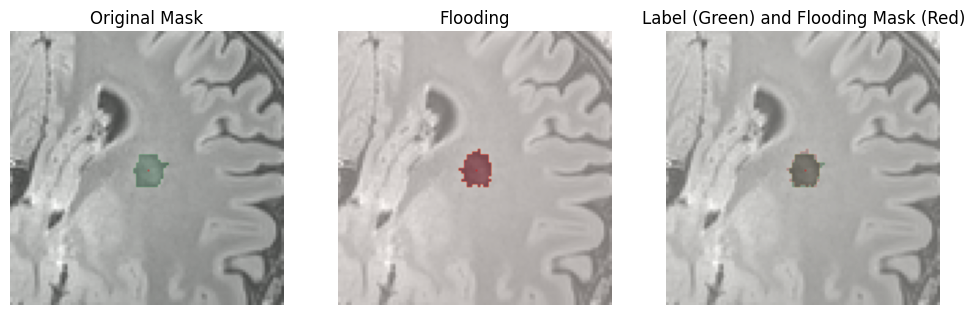

Dice Score:  0.9122807017543859
Sensitivity Score:  0.9203539823008849
Specificity Score:  0.9988874279356731
Average Hausdorff Distance:  2.0


In [560]:
# Flooding Segmentation
segmented_image = segmentation.flood(crop_area(ani_image), adjusted_seed, connectivity=1, tolerance=31)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.3)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.imshow(segmented_image, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Flooding")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.imshow(segmented_image, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and Flooding Mask (Red)")
plt.axis("off")

plt.show()

eval_print_scores(crop_area(mask), segmented_image)

### Fuzzy C-Means

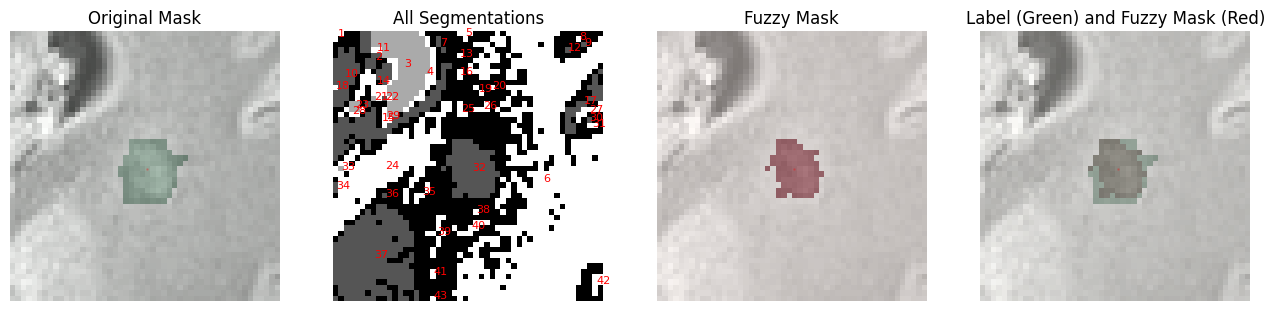

Dice Score:  0.8350515463917526
Sensitivity Score:  0.7168141592920354
Specificity Score:  1.0
Average Hausdorff Distance:  3.1622776601683795


In [320]:
# FCM Segmentation

# Flatten image
shape = crop_area(image).shape
image_flattened = crop_area(image).reshape(-1)

# FCM
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    image_flattened.reshape(1, -1),
    4, # Number of clusters
    1.5, # Fuzziness parameter
    error=0.0001,
    maxiter=1000,
    init=None)

# cluster membership
labels = np.argmax(u, axis=0)
segmented_image = labels.reshape(shape)

labels = measure.label(segmented_image)
properties = measure.regionprops(labels)
# label of the segment at the seed point
seed_label = labels[adjusted_seed]
# Create a mask for the segment
segment_mask = labels == seed_label


plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(crop_area(image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.3)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(segmented_image, cmap="gray"), plt.title("All Segmentations"), plt.axis("off")
for prop in properties:
    centroid = prop.centroid
    plt.text(centroid[1], centroid[0], str(prop.label), color="red", fontsize=8)

plt.subplot(1, 4, 3)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(segment_mask, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Fuzzy Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(segment_mask, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and Fuzzy Mask (Red)")
plt.axis("off")

plt.show()

eval_print_scores(crop_area(mask), segment_mask)

Anisotropic Diffusion

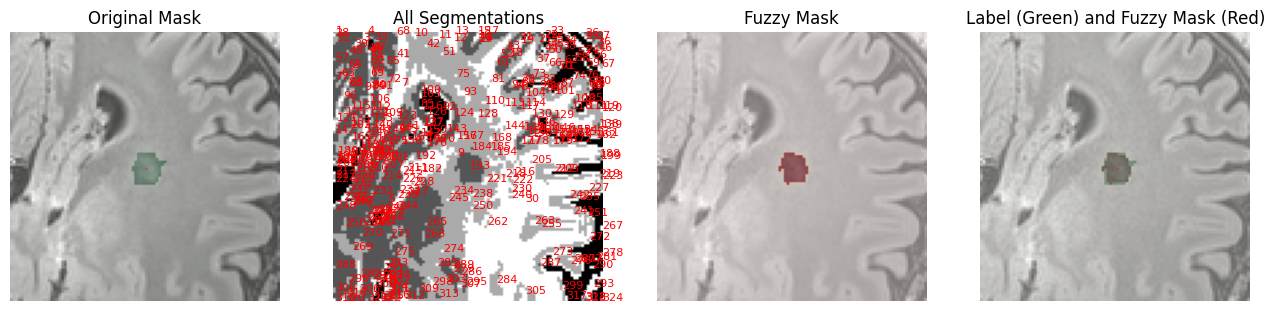

Dice Score:  0.8932038834951457
Sensitivity Score:  0.8141592920353983
Specificity Score:  0.9998988570850612
Average Hausdorff Distance:  2.8284271247461903


In [455]:
# FCM Segmentation

# Flatten image
shape = crop_area(ani_image).shape
image_flattened = crop_area(ani_image).reshape(-1)

# FCM
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    image_flattened.reshape(1, -1),
    4, # Number of clusters
    6, # Fuzziness parameter
    error=0.001,
    maxiter=100,
    init=None)

# cluster membership
labels = np.argmax(u, axis=0)
segmented_image = labels.reshape(shape)

labels = measure.label(segmented_image)
properties = measure.regionprops(labels)
# label of the segment at the seed point
seed_label = labels[adjusted_seed]
# Create a mask for the segment
segment_mask = labels == seed_label


plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.3)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(segmented_image, cmap="gray"), plt.title("All Segmentations"), plt.axis("off")
for prop in properties:
    centroid = prop.centroid
    plt.text(centroid[1], centroid[0], str(prop.label), color="red", fontsize=8)

plt.subplot(1, 4, 3)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.imshow(segment_mask, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Fuzzy Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(segment_mask, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and Fuzzy Mask (Red)")
plt.axis("off")

plt.show()

eval_print_scores(crop_area(mask), segment_mask)

### Felzenszwalb 

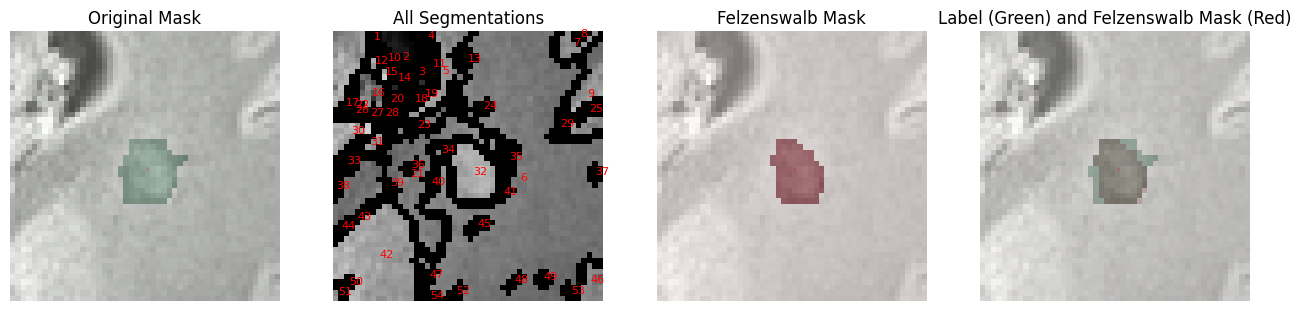

Dice Score:  0.883495145631068
Sensitivity Score:  0.8053097345132744
Specificity Score:  0.9991621281943862
Average Hausdorff Distance:  2.8284271247461903


In [321]:
# Applying Felzenszwalb
segments_fz = segmentation.felzenszwalb(crop_area(image), scale=50, sigma=0.5, min_size=3)

# Creating Boundaries
label = segmentation.mark_boundaries(crop_area(image), segments_fz, (0, 0, 0),mode="thick")

# Find the unique segments and their centroids
regions = measure.regionprops(segments_fz)
centroids = [region.centroid for region in regions]

# Selecting a specific segment
selected_segment_id = segments_fz[adjusted_seed]
selected_segment = np.where(segments_fz == selected_segment_id, 1, 0)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(crop_area(image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.3)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(label, cmap="gray"), plt.title("All Segmentations"), plt.axis("off")
for reg in regions:
    centroid = reg.centroid
    plt.text(centroid[1], centroid[0], str(reg.label), color="red", fontsize=8)

plt.subplot(1, 4, 3)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(selected_segment, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Felzenswalb Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(selected_segment, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and Felzenswalb Mask (Red)")
plt.axis("off")

plt.show()

eval_print_scores(crop_area(mask), selected_segment)

Anisotropic Diffusion

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


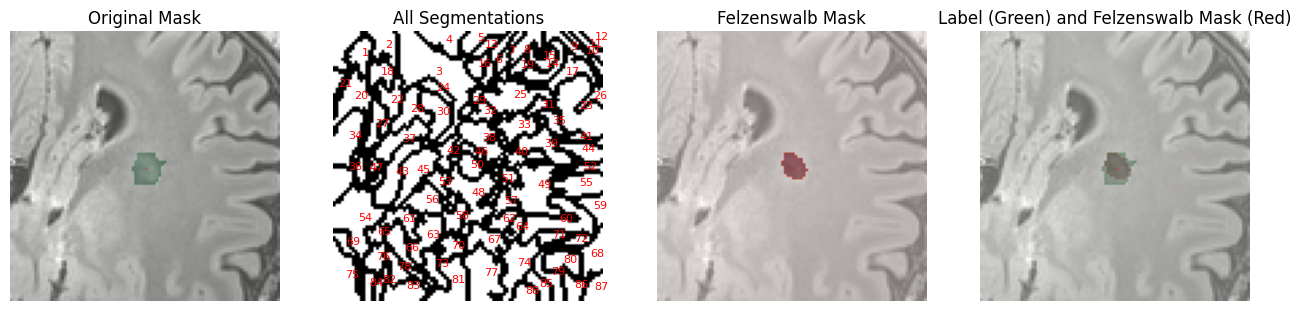

Dice Score:  0.7582417582417582
Sensitivity Score:  0.6106194690265486
Specificity Score:  1.0
Average Hausdorff Distance:  3.605551275463989


In [554]:
# Applying Felzenszwalb
segments_fz = segmentation.felzenszwalb(crop_area(ani_image), scale=100, sigma=0.0001, min_size=30)

# Creating Boundaries
label = segmentation.mark_boundaries(crop_area(ani_image), segments_fz, (0, 0, 0),mode="thick")

# Find the unique segments and their centroids
regions = measure.regionprops(segments_fz)
centroids = [region.centroid for region in regions]

# Selecting a specific segment
selected_segment_id = segments_fz[adjusted_seed]
selected_segment = np.where(segments_fz == selected_segment_id, 1, 0)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.3)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(label, cmap="gray"), plt.title("All Segmentations"), plt.axis("off")
for reg in regions:
    centroid = reg.centroid
    plt.text(centroid[1], centroid[0], str(reg.label), color="red", fontsize=8)

plt.subplot(1, 4, 3)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.imshow(selected_segment, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Felzenswalb Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.imshow(selected_segment, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and Felzenswalb Mask (Red)")
plt.axis("off")

plt.show()

eval_print_scores(crop_area(mask), selected_segment)

### SLIC

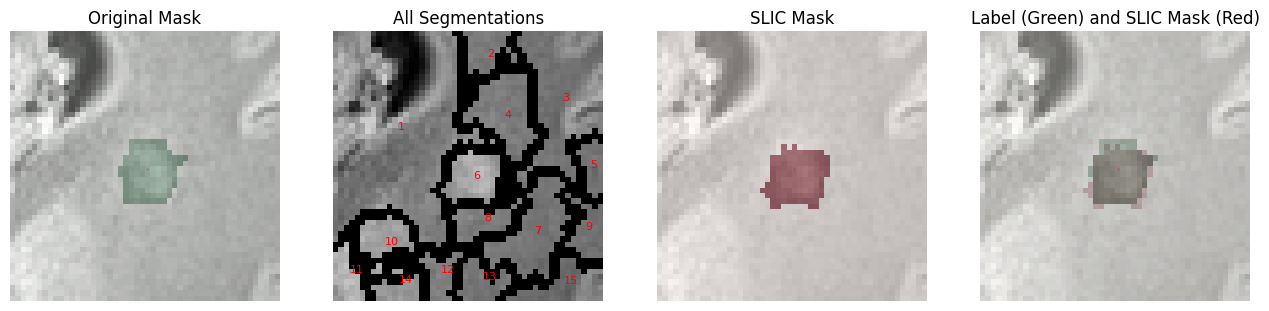

Dice Score:  0.8660714285714286
Sensitivity Score:  0.8584070796460177
Specificity Score:  0.9941348973607038
Average Hausdorff Distance:  2.0


In [322]:
# Applying SLIC
segments_slic = segmentation.slic(crop_area(image), n_segments=40, compactness=0.02, sigma=0.001, start_label=1, channel_axis=None)

label = segmentation.mark_boundaries(crop_area(image), segments_slic, (0, 0, 0),mode="thick")

# Find the unique segments and their centroids
regions = measure.regionprops(segments_slic)
centroids = [region.centroid for region in regions]

# Selecting a specific segment
selected_segment_id = segments_slic[adjusted_seed]
selected_segment = np.where(segments_slic == selected_segment_id, 1, 0)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(crop_area(image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.3)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(label, cmap="gray"), plt.title("All Segmentations"), plt.axis("off")
for reg in regions:
    centroid = reg.centroid
    plt.text(centroid[1], centroid[0], str(reg.label), color="red", fontsize=8)

plt.subplot(1, 4, 3)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(selected_segment, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("SLIC Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(selected_segment, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and SLIC Mask (Red)")
plt.axis("off")

plt.show()


eval_print_scores(crop_area(mask), selected_segment)

Anisotropic Diffusion

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


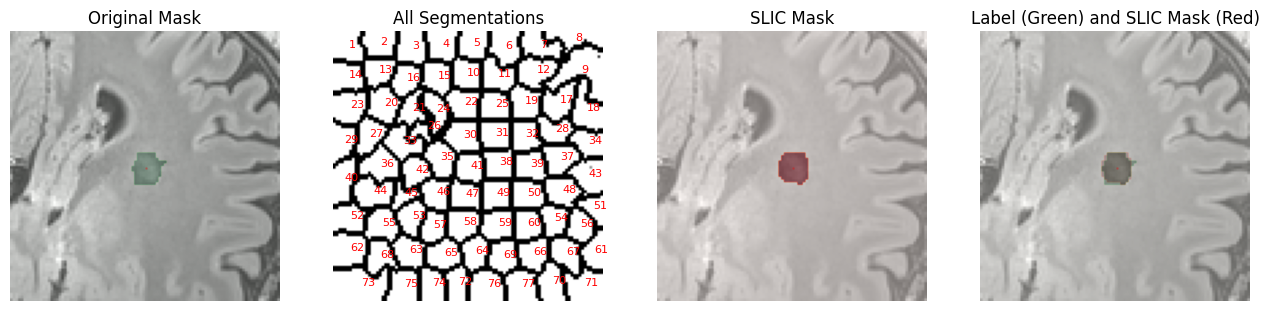

Dice Score:  0.911504424778761
Sensitivity Score:  0.911504424778761
Specificity Score:  0.9989885708506119
Average Hausdorff Distance:  2.0


In [520]:
# Applying SLIC
segments_slic = segmentation.slic(crop_area(ani_image), n_segments=80, compactness=0.16, sigma=1.25, start_label=1, channel_axis=None)

label = segmentation.mark_boundaries(crop_area(ani_image), segments_slic, (0, 0, 0),mode="thick")

# Find the unique segments and their centroids
regions = measure.regionprops(segments_slic)
centroids = [region.centroid for region in regions]

# Selecting a specific segment
selected_segment_id = segments_slic[adjusted_seed]
selected_segment = np.where(segments_slic == selected_segment_id, 1, 0)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.3)
plt.title("Original Mask")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(label, cmap="gray"), plt.title("All Segmentations"), plt.axis("off")
for reg in regions:
    centroid = reg.centroid
    plt.text(centroid[1], centroid[0], str(reg.label), color="red", fontsize=8)

plt.subplot(1, 4, 3)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.imshow(selected_segment, cmap="Reds", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("SLIC Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(crop_area(ani_image), cmap="gray")
plt.imshow(selected_segment, cmap="Reds", alpha=0.25)
plt.imshow(crop_area(mask), cmap="Greens", alpha=0.25)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Label (Green) and SLIC Mask (Red)")
plt.axis("off")

plt.show()


eval_print_scores(crop_area(mask), selected_segment)

### Fine-Tuning

#### Data Load

In [27]:
# Loading data for each plane
def load_data(data_directory, load_limit = 5, fixed_image_size = False):
    sag_images = []
    sag_label_images = []
    cor_images = []
    cor_label_images = []
    tra_images = []
    tra_label_images = []

    folder_count = 0
    
    for folder in os.listdir(data_directory):
        if "sub" in folder and load_limit != 0:
            # print(f"Processing {folder}")

            try:
                t2_vol = nib.load(data_directory + f"/{folder}/anat/{folder}_acq-T2sel_FLAIR.nii.gz")
                t2roi_vol = nib.load(data_directory + f"/{folder}/anat/{folder}_acq-T2sel_FLAIR_roi.nii.gz")
            except:
                # print(f"Error loading {folder}")
                continue

            t2_data = t2_vol.get_fdata()
            t2roi_data = t2roi_vol.get_fdata()
                
            # Sagittal Plane
            for i in range(t2_data.shape[0]):
                image = t2_data[i, :, :]
                label_image = t2roi_data[i, :, :]

                if fixed_image_size and image.shape != (256, 256) and label_image.shape != (256, 256):
                    continue
                sag_images.append(image)
                sag_label_images.append(label_image)

            # Coronal Plane
            for i in range(t2_data.shape[1]):
                image = t2_data[:, i, :]
                label_image = t2roi_data[:, i, :]
                
                if fixed_image_size and image.shape != (160, 256) and label_image.shape != (256, 256):
                    continue
                cor_images.append(image)
                cor_label_images.append(label_image)

            # Transverse Plane
            for i in range(t2_data.shape[2]):
                image = t2_data[:, :, i]
                label_image = t2roi_data[:, :, i]

                if fixed_image_size and image.shape != (160, 256) and label_image.shape != (256, 256):
                    continue
                tra_images.append(image)
                tra_label_images.append(label_image)
            
            folder_count += 1
            load_limit -= 1
    
    print(f"Loaded {folder_count} folders")

    return sag_images, sag_label_images, cor_images, cor_label_images, tra_images, tra_label_images

In [28]:
current_directory = os.getcwd()
data_directory = current_directory + r"\Datasets\ds004199"
load_limit = 20 # 78 subjects maximum

sag_images, sag_label_images, cor_images, cor_label_images, tra_images, tra_label_images = load_data(data_directory, load_limit)

print("List lengths: ", len(sag_images), len(sag_label_images), len(cor_images), len(cor_label_images), len(tra_images), len(tra_label_images))

Loaded 20 folders
List lengths:  3200 3200 5120 5120 5120 5120


#### Data Filtering

In [29]:
# Pair image that has a positive lesion
sag_images_lesion = []
sag_label_lesion = []
cor_images_lesion = []
cor_label_lesion = []
tra_images_lesion = []
tra_label_lesion = []

for i in range(len(sag_label_images)-1, -1, -1):
    if sum(sag_label_images[i].flatten()) != 0:
        sag_images_lesion.append(sag_images.pop(i))
        sag_label_lesion.append(sag_label_images.pop(i))

for i in range(len(cor_label_images)-1, -1, -1):
    if sum(cor_label_images[i].flatten()) != 0:
        cor_images_lesion.append(cor_images.pop(i))
        cor_label_lesion.append(cor_label_images.pop(i))

for i in range(len(tra_label_images)-1, -1, -1):
    if sum(tra_label_images[i].flatten()) != 0:
        tra_images_lesion.append(tra_images.pop(i))
        tra_label_lesion.append(tra_label_images.pop(i))

print("No Lesion List lengths: ", len(sag_images), len(sag_label_images), len(cor_images), len(cor_label_images), len(tra_images), len(tra_label_images))
print("Lesion List lengths: ", len(sag_images_lesion), len(sag_label_lesion), len(cor_images_lesion), len(cor_label_lesion), len(tra_images_lesion), len(tra_label_lesion))


No Lesion List lengths:  2685 2685 4632 4632 4685 4685
Lesion List lengths:  515 515 488 488 435 435


#### Data Augmentation

In [30]:
# Data augmentation function
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        # Original image
        augmented_images.append(image)
        augmented_labels.append(label)

        # Rotate +90 degrees
        augmented_images.append(np.rot90(image, k=1))
        augmented_labels.append(np.rot90(label, k=1))

        # Rotate -90 degrees
        augmented_images.append(np.rot90(image, k=3))
        augmented_labels.append(np.rot90(label, k=3))

        # Flip on the y-axis
        augmented_images.append(np.flip(image, axis=1))
        augmented_labels.append(np.flip(label, axis=1))

    return augmented_images, augmented_labels

# Perform data augmentation
augmented_sag_images, augmented_sag_label_images = augment_data(sag_images_lesion, sag_label_lesion)
augmented_cor_images, augmented_cor_label_images = augment_data(cor_images_lesion, cor_label_lesion)
augmented_tra_images, augmented_tra_label_images = augment_data(tra_images_lesion, tra_label_lesion)

print("List lengths after data augmentation: ", len(augmented_sag_images), len(augmented_sag_label_images), len(augmented_cor_images), len(augmented_cor_label_images), len(augmented_tra_images), len(augmented_tra_label_images))


List lengths after data augmentation:  2060 2060 1952 1952 1740 1740


In [31]:
# Concatenate the lists of images and labels
conc_type = "augmented" # augmented or lesion

if conc_type == "augmented":
    sagittal_balance = len(augmented_sag_images) / len(sag_images)
    coronal_balance = len(augmented_cor_images) / len(cor_images)
    transverse_balance = len(augmented_tra_images) / len(tra_images)

    sag_images_combined = sag_images + augmented_sag_images
    sag_label_images_combined = sag_label_images + augmented_sag_label_images

    cor_images_combined = cor_images + augmented_cor_images
    cor_label_images_combined = cor_label_images + augmented_cor_label_images

    tra_images_combined = tra_images + augmented_tra_images
    tra_label_images_combined = tra_label_images + augmented_tra_label_images

elif conc_type == "lesion":
    sag_images_combined = sag_images_lesion
    sag_label_images_combined = sag_label_lesion

    cor_images_combined = cor_images_lesion
    cor_label_images_combined = cor_label_lesion

    tra_images_combined = tra_images_lesion
    tra_label_images_combined = tra_label_lesion

else:
    sagittal_balance = len(sag_images_lesion) / len(sag_images)
    coronal_balance = len(cor_images_lesion) / len(cor_images)
    transverse_balance = len(tra_images_lesion) / len(tra_images)

    sag_images_combined = sag_images + sag_images_lesion
    sag_label_images_combined = sag_label_images + sag_label_lesion

    cor_images_combined = cor_images + cor_images_lesion
    cor_label_images_combined = cor_label_images + cor_label_lesion

    tra_images_combined = tra_images + tra_images_lesion
    tra_label_images_combined = tra_label_images + tra_label_lesion

print("Combined List lengths: ", len(sag_images_combined), len(sag_label_images_combined), len(cor_images_combined), len(cor_label_images_combined), len(tra_images_combined), len(tra_label_images_combined))


Combined List lengths:  4745 4745 6584 6584 6425 6425


In [32]:
del sag_images, sag_label_images, cor_images, cor_label_images, tra_images, tra_label_images

Image Padding

In [33]:
def pad_images(images):
    padded_images = []
    for image in images:
        height, width = image.shape
        if height < 256 or width < 256:
            pad_height = max(0, (256 - height) // 2)
            pad_width = max(0, (256 - width) // 2)
            padded_image = np.pad(image, ((pad_height, 256 - height - pad_height), (pad_width, 256 - width - pad_width)), mode='constant')
        else:
            padded_image = image[:256, :256]
        padded_images.append(padded_image)
    return padded_images

sag_images_combined_padded = pad_images(sag_images_combined)
sag_label_images_combined_padded = pad_images(sag_label_images_combined)

cor_images_combined_padded = pad_images(cor_images_combined)
cor_label_images_combined_padded = pad_images(cor_label_images_combined)

tra_images_combined_padded = pad_images(tra_images_combined)
tra_label_images_combined_padded = pad_images(tra_label_images_combined)

print("Padded List lengths: ", len(sag_images_combined_padded), len(sag_label_images_combined_padded), len(cor_images_combined_padded), len(cor_label_images_combined_padded), len(tra_images_combined_padded), len(tra_label_images_combined_padded))

Padded List lengths:  4745 4745 6584 6584 6425 6425


In [ ]:
del sag_images_combined, sag_label_images_combined, cor_images_combined, cor_label_images_combined, tra_images_combined, tra_label_images_combined

Anisotropic Diffusion

c:\Users\chris\anaconda3\envs\tf-directml\lib\site-packages\medpy\filter\smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
c:\Users\chris\anaconda3\envs\tf-directml\lib\site-packages\medpy\filter\smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


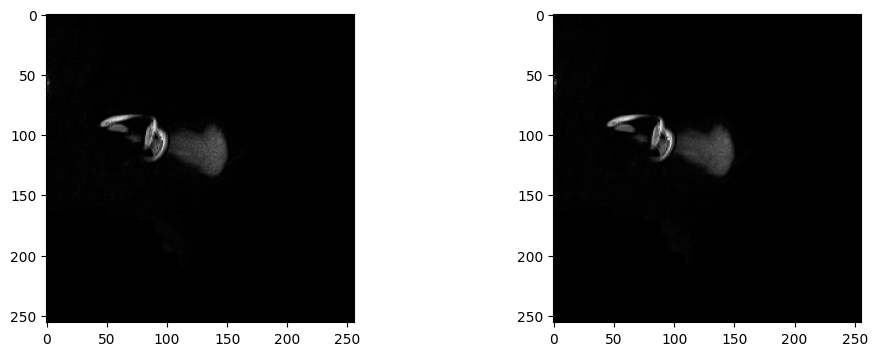

In [36]:
niter = 15
kappa = 20
gamma = 0.01
option = 1

# Apply anisotropic diffusion to each image in the combined lists
sag_images_diffused = list(map(lambda image: anisotropic_diffusion(image, niter=niter, kappa=kappa, gamma=gamma, option=option), sag_images_combined_padded))
cor_images_diffused = list(map(lambda image: anisotropic_diffusion(image, niter=niter, kappa=kappa, gamma=gamma, option=option), cor_images_combined_padded))
tra_images_diffused = list(map(lambda image: anisotropic_diffusion(image, niter=niter, kappa=kappa, gamma=gamma, option=option), tra_images_combined_padded))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(sag_images_combined_padded[0], cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(sag_images_diffused[0], cmap="gray")

plt.show()

In [37]:
del sag_images_combined_padded, cor_images_combined_padded, tra_images_combined_padded

In [39]:
# Reassign the lists for memory efficiency
sag_images = sag_images_diffused
sag_label_images = sag_label_images_combined_padded
cor_images = cor_images_diffused
cor_label_images = cor_label_images_combined_padded
tra_images = tra_images_diffused
tra_label_images = tra_label_images_combined_padded

In [40]:
del sag_images_diffused, cor_images_diffused, tra_images_diffused, sag_label_images_combined_padded, cor_label_images_combined_padded, tra_label_images_combined_padded

Statistical Measures

In [74]:
# Calculate statistics for sagittal images
sag_positive_slices = [sag_label_images[i] for i in range(len(sag_label_images)) if np.sum(sag_label_images[i]) > 0]
sag_std = np.std(sag_positive_slices, axis=(1, 2))
sag_mean = np.mean(sag_positive_slices, axis=(1, 2))
sag_median = np.median(sag_positive_slices, axis=(1, 2))
sag_min = np.min(sag_positive_slices, axis=(1, 2))
sag_max = np.max(sag_positive_slices, axis=(1, 2))

# Calculate statistics for coronal images
cor_positive_slices = [cor_label_images[i] for i in range(len(cor_label_images)) if np.sum(cor_label_images[i]) > 0]
cor_std = np.std(cor_positive_slices, axis=(1, 2))
cor_mean = np.mean(cor_positive_slices, axis=(1, 2))
cor_median = np.median(cor_positive_slices, axis=(1, 2))
cor_min = np.min(cor_positive_slices, axis=(1, 2))
cor_max = np.max(cor_positive_slices, axis=(1, 2))

# Calculate statistics for transverse images
tra_positive_slices = [tra_label_images[i] for i in range(len(tra_label_images)) if np.sum(tra_label_images[i]) > 0]
tra_std = np.std(tra_positive_slices, axis=(1, 2))
tra_mean = np.mean(tra_positive_slices, axis=(1, 2))
tra_median = np.median(tra_positive_slices, axis=(1, 2))
tra_min = np.min(tra_positive_slices, axis=(1, 2))
tra_max = np.max(tra_positive_slices, axis=(1, 2))

print("Statistics for sagittal images")
print("---------------------------")
print("Standard Deviation:", np.std(sag_std))
print("Mean:", np.mean(sag_mean))
print("Median:", np.median(sag_median))
print("Minimum:", np.min(sag_min))
print("Maximum:", np.max(sag_max))

print("Statistics for coronal images")
print("---------------------------")
print("Standard Deviation:", np.std(cor_std))
print("Mean:", np.mean(cor_mean))
print("Median:", np.median(cor_median))
print("Minimum:", np.min(cor_min))
print("Maximum:", np.max(cor_max))

print("Statistics for transverse images")
print("---------------------------")
print("Standard Deviation:", np.std(tra_std))
print("Mean:", np.mean(tra_mean))
print("Median:", np.median(tra_median))
print("Minimum:", np.min(tra_min))
print("Maximum:", np.max(tra_max))


Statistics for sagittal images
---------------------------
Standard Deviation: 0.032036463914884
Mean: 0.002830601405430507
Median: 0.0
Minimum: 0.0
Maximum: 1.0
Statistics for coronal images
---------------------------
Standard Deviation: 0.02743576283211765
Mean: 0.003094617744469132
Median: 0.0
Minimum: 0.0
Maximum: 1.0
Statistics for transverse images
---------------------------
Standard Deviation: 0.031241166766289182
Mean: 0.003057220551182496
Median: 0.0
Minimum: 0.0
Maximum: 1.0


In [80]:
# Calculate the average lesion size
lesion_sizes = []
for label_image in sag_label_images + cor_label_images + tra_label_images:
    unique_labels, label_counts = np.unique(label_image, return_counts=True)
    lesion_sizes.extend(label_counts[1:])
avg_lesion_size = np.mean(lesion_sizes)
med_lesion_size = np.median(lesion_sizes)

# Calculate the minimum and maximum lesion size
min_lesion_size = np.min(lesion_sizes)
max_lesion_size = np.max(lesion_sizes)
std_lesion_sizes = np.std(lesion_sizes)


# Print the table
print("Statistics for Lesion Masks")
print("---------------------------")
print(f"Average Lesion Size: {avg_lesion_size}")
print(f"Median Lesion Size: {med_lesion_size}")
print(f"SD of Lesion Sizes: {std_lesion_sizes}")
print(f"Minimum Lesion Size: {min_lesion_size}")
print(f"Maximum Lesion Size: {max_lesion_size}")

Statistics for Lesion Masks
---------------------------
Average Lesion Size: 195.91875923190545
Median Lesion Size: 101.0
SD of Lesion Sizes: 294.76711517520334
Minimum Lesion Size: 1
Maximum Lesion Size: 2086


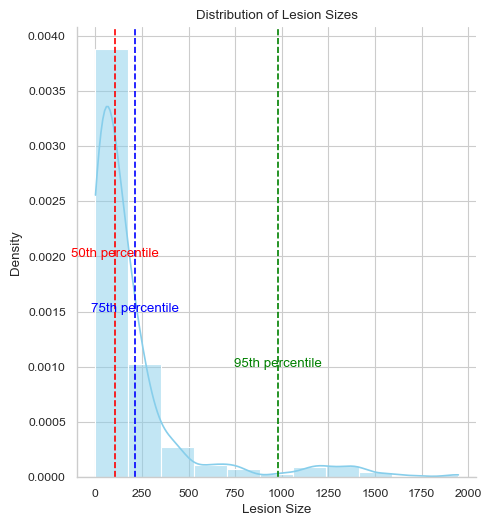

In [128]:
sns.set_style("whitegrid")
sns.set_context("paper")

# Plot the distribution frequency with a smoothed line
displot = sns.displot(lesion_sizes, kind="hist", bins=11, kde=True, stat="density", color="skyblue", common_norm=False)
displot.set_axis_labels("Lesion Size", "Density")
plt.title("Distribution of Lesion Sizes")

# Plot the 80% line in red
plt.axvline(np.percentile(lesion_sizes, 50), color='red', linestyle='--')
plt.axvline(np.percentile(lesion_sizes, 75), color='blue', linestyle='--')
plt.axvline(np.percentile(lesion_sizes, 95), color='green', linestyle='--')

plt.text(np.percentile(lesion_sizes, 50), 0.002, "50th percentile", color='red', ha='center')
plt.text(np.percentile(lesion_sizes, 75), 0.0015, "75th percentile", color='blue', ha='center')
plt.text(np.percentile(lesion_sizes, 95), 0.001, "95th percentile", color='green', ha='center')

plt.show()


Statistics for Lesion Masks (Sagittal Plane)
---------------------------
Average Lesion Size: 185.50629370629372
Median Lesion Size: 87.0
SD of Lesion Sizes: 334.1471279350496
Minimum Lesion Size: 1
Maximum Lesion Size: 2086


Text(0.5, 1.0, 'Distribution of Lesion Sizes (Sagittal Plane)')

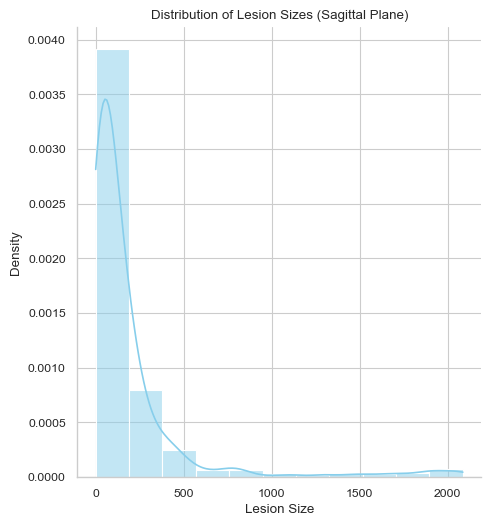

In [102]:
# Calculate the average lesion size
lesion_sizes = []
for label_image in sag_label_images:
    unique_labels, label_counts = np.unique(label_image, return_counts=True)
    lesion_sizes.extend(label_counts[1:])
avg_lesion_size = np.mean(lesion_sizes)
med_lesion_size = np.median(lesion_sizes)

# Calculate the minimum and maximum lesion size
min_lesion_size = np.min(lesion_sizes)
max_lesion_size = np.max(lesion_sizes)
std_lesion_sizes = np.std(lesion_sizes)


# Print the table
print("Statistics for Lesion Masks (Sagittal Plane)")
print("---------------------------")
print(f"Average Lesion Size: {avg_lesion_size}")
print(f"Median Lesion Size: {med_lesion_size}")
print(f"SD of Lesion Sizes: {std_lesion_sizes}")
print(f"Minimum Lesion Size: {min_lesion_size}")
print(f"Maximum Lesion Size: {max_lesion_size}")

# Plot the distribution frequency with a smoothed line
sns.set_style("whitegrid")
sns.set_context("paper") 

displot = sns.displot(lesion_sizes, kind="hist", bins=11, kde=True, stat="density", color="skyblue", common_norm=False)
displot.set_axis_labels("Lesion Size", "Density")
plt.title("Distribution of Lesion Sizes (Sagittal Plane)")

Statistics for Lesion Masks (Coronal Plane)
---------------------------
Average Lesion Size: 202.80886850152905
Median Lesion Size: 120.5
SD of Lesion Sizes: 232.01926099974222
Minimum Lesion Size: 1
Maximum Lesion Size: 1233


Text(0.5, 1.0, 'Distribution of Lesion Sizes (Coronal Plane)')

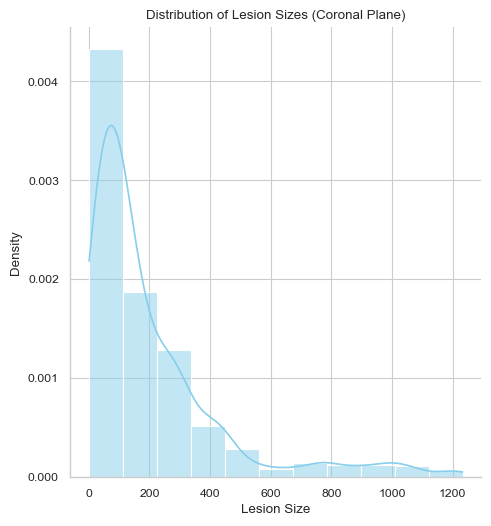

In [103]:
# Calculate the average lesion size
lesion_sizes = []
for label_image in cor_label_images:
    unique_labels, label_counts = np.unique(label_image, return_counts=True)
    lesion_sizes.extend(label_counts[1:])
avg_lesion_size = np.mean(lesion_sizes)
med_lesion_size = np.median(lesion_sizes)

# Calculate the minimum and maximum lesion size
min_lesion_size = np.min(lesion_sizes)
max_lesion_size = np.max(lesion_sizes)
std_lesion_sizes = np.std(lesion_sizes)


# Print the table
print("Statistics for Lesion Masks (Coronal Plane)")
print("---------------------------")
print(f"Average Lesion Size: {avg_lesion_size}")
print(f"Median Lesion Size: {med_lesion_size}")
print(f"SD of Lesion Sizes: {std_lesion_sizes}")
print(f"Minimum Lesion Size: {min_lesion_size}")
print(f"Maximum Lesion Size: {max_lesion_size}")

# Plot the distribution frequency with a smoothed line
sns.set_style("whitegrid")
sns.set_context("paper") 

displot = sns.displot(lesion_sizes, kind="hist", bins=11, kde=True, stat="density", color="skyblue", common_norm=False)
displot.set_axis_labels("Lesion Size", "Density")
plt.title("Distribution of Lesion Sizes (Coronal Plane)")

Statistics for Lesion Masks (Transverse Plane)
---------------------------
Average Lesion Size: 200.35800604229607
Median Lesion Size: 104.5
SD of Lesion Sizes: 304.3184653075491
Minimum Lesion Size: 1
Maximum Lesion Size: 1947


Text(0.5, 1.0, 'Distribution of Lesion Sizes (Transverse Plane)')

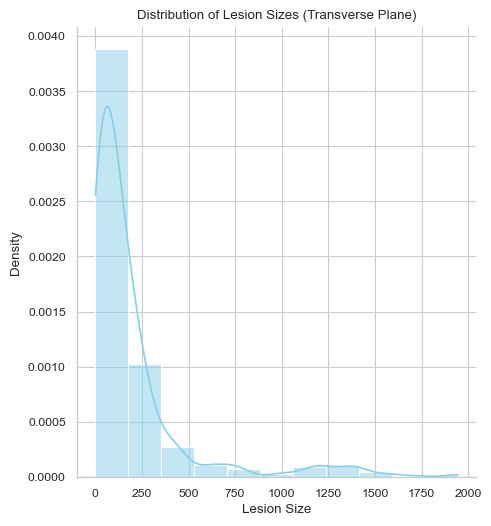

In [104]:
# Calculate the average lesion size
lesion_sizes = []
for label_image in tra_label_images:
    unique_labels, label_counts = np.unique(label_image, return_counts=True)
    lesion_sizes.extend(label_counts[1:])
avg_lesion_size = np.mean(lesion_sizes)
med_lesion_size = np.median(lesion_sizes)

# Calculate the minimum and maximum lesion size
min_lesion_size = np.min(lesion_sizes)
max_lesion_size = np.max(lesion_sizes)
std_lesion_sizes = np.std(lesion_sizes)


# Print the table
print("Statistics for Lesion Masks (Transverse Plane)")
print("---------------------------")
print(f"Average Lesion Size: {avg_lesion_size}")
print(f"Median Lesion Size: {med_lesion_size}")
print(f"SD of Lesion Sizes: {std_lesion_sizes}")
print(f"Minimum Lesion Size: {min_lesion_size}")
print(f"Maximum Lesion Size: {max_lesion_size}")

# Plot the distribution frequency with a smoothed line
sns.set_style("whitegrid")
sns.set_context("paper") 

displot = sns.displot(lesion_sizes, kind="hist", bins=11, kde=True, stat="density", color="skyblue", common_norm=False)
displot.set_axis_labels("Lesion Size", "Density")
plt.title("Distribution of Lesion Sizes (Transverse Plane)")

Positive Lesion Sets

In [46]:
sag_pos_images = []
sag_pos_masks = []
cor_pos_images = []
cor_pos_masks = []
tra_pos_images = []
tra_pos_masks = []

for i in range(len(sag_label_images)):
    if np.any(sag_label_images[i] > 0):
        sag_pos_images.append(sag_images[i])
        sag_pos_masks.append(sag_label_images[i])
        
for i in range(len(cor_label_images)):
    if np.any(cor_label_images[i] > 0):
        cor_pos_images.append(cor_images[i])
        cor_pos_masks.append(cor_label_images[i])
        
for i in range(len(tra_label_images)):
    if np.any(tra_label_images[i] > 0):
        tra_pos_images.append(tra_images[i])
        tra_pos_masks.append(tra_label_images[i])

print("Positive List lengths: ", len(sag_pos_images), len(sag_pos_masks), len(cor_pos_images), len(cor_pos_masks), len(tra_pos_images), len(tra_pos_masks))

Positive List lengths:  77 77 85 85 75 75


#### Segmentation

In [255]:
def segmentation(params, seg_type="SLIC", eval_score="DSC", axis="sagittal"):
    """
    params: Dictionary of parameters for segmentation: any dictionary size
    seg_type: Type of segmentation to be used: RG, FL, FCM, SLIC, Felzenszwalb
        RG: Region Growing
            - connectivity: Connectivity of pixels (4 or 8)
            - threshold: Threshold value for region growing
        FL: Flooding
            - connectivity: Connectivity of pixels (2, 4, 8)
            - tolerance: Tolerance value for flooding
        FCM: Fuzzy C-Means
            - n_clusters: Number of clusters
            - m: Fuzziness parameter
            - error: Stopping criterion
            - maxiter: Maximum number of iterations
        Felzenszwalb: Felzenszwalb
            - scale: Higher means larger clusters
            - sigma: Width of Gaussian kernel for pre-processing for each dimension of the image
            - min_size: Minimum component size. Enforced using postprocessing.
        SLIC: Simple Linear Iterative Clustering
            - n_segments: Number of segments
            - compactness: Balances color proximity and space proximity
            - sigma: Width of Gaussian kernel for pre-processing for each dimension of the image
    eval_score: Evaluation metric to be used: DSC, IoU, SENS, SPEC, PREC, ACC, AHD
    axis: Axis of image to be segmented: sagittal, coronal, transverse
    """
    # Create a list of all possible combinations of parameters
    combinations = list(itertools.product(*(params[key] for key in params)))
    param_combinations = [dict(zip(params.keys(), combination)) for combination in combinations]
    per_image_scores = []
    param_ranking = {json.dumps(item): 0 for item in param_combinations}

    # Define data based on axis
    if axis == "sagittal":
        data = sag_pos_images
        label_data = sag_pos_masks
    elif axis == "coronal":
        data = cor_pos_images
        label_data = cor_pos_masks
    elif axis == "transverse":
        data = tra_pos_images
        label_data = tra_pos_masks

     # Start computation time tracking
    start_time = time.time() 

    # Loop through all combinations of parameters on each image
    for i in range(len(data)):
        print(f"Processing image {i+1} of {len(data)}")
        time.sleep(0.01)
        clear_output(wait=True)

        # Label Seedpoint per image
        seed_points = find_seeds(label_data[i])
        temp_scores = []

        if seg_type == "RG":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(region_growing(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)
        
        elif seg_type == "FL":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(flooding(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)

        elif seg_type == "FCM":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(fuzzy_cmeans(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)

        elif seg_type == "SLIC":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(slic(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)

        elif seg_type == "Felzenszwalb":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(felzenszwalb(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)

        # Append per image scores and param_combinations
        
        per_image_scores.append(max(temp_scores))
        param_ranking[json.dumps(param_combinations[temp_scores.index(max(temp_scores))])] += 1
        print(f"Image {i+1} processed with {seg_type} by {param_combinations[temp_scores.index(max(temp_scores))]}")
        # print(temp_scores)
        # print(param_ranking)
        time.sleep(0.01)
        clear_output(wait=True)
    
    # End computation time tracking
    end_time = time.time()
    computation_time = end_time - start_time

    # Average score of all images with the best parameters
    best_params = max(param_ranking, key=param_ranking.get)
    best_params = json.loads(best_params)
    
    avg_scores = []
    best_param_masks = []
    
    if seg_type == "RG":
        for i in range(len(data)):
            best_param_masks.append(region_growing(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5), plt.title("Original Mask")
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray"), plt.title("Segmented Mask")
        plt.imshow(region_growing(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()
        
    
    elif seg_type == "FL":
        for i in range(len(data)):
            best_param_masks.append(flooding(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5), plt.title("Original Mask")
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray"), plt.title("Segmented Mask")
        plt.imshow(flooding(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()
    
    elif seg_type == "FCM":
        for i in range(len(data)):
            best_param_masks.append(fuzzy_cmeans(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5), plt.title("Original Mask")
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray"), plt.title("Segmented Mask")
        plt.imshow(fuzzy_cmeans(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()
    
    elif seg_type == "SLIC":
        for i in range(len(data)):
            best_param_masks.append(slic(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5), plt.title("Original Mask")
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray"), plt.title("Segmented Mask")
        plt.imshow(slic(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()
    
    elif seg_type == "Felzenszwalb":
        for i in range(len(data)):
            best_param_masks.append(felzenszwalb(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))            
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5)
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray"), plt.title("Segmented Mask")
        plt.imshow(felzenszwalb(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()

    
    average_score = sum(avg_scores) / len(avg_scores)
    best_score = max(avg_scores)

    return computation_time, best_params, average_score, best_score


#### Performance Evaluation

In [53]:
sns.set_style("white")

Region-Growing

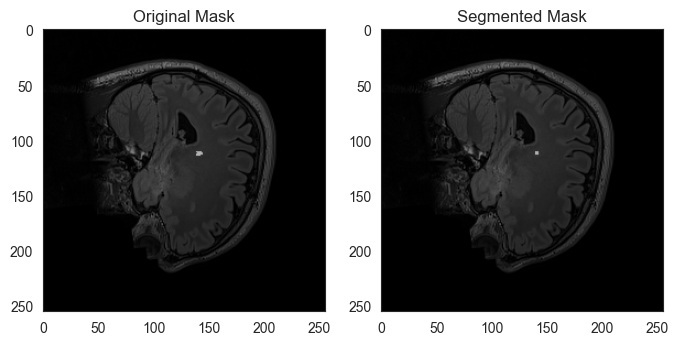

Computation Time: 17.95643949508667
Best Parameters: {'connectivity': 4, 'threshold': 100}
Average Score: 0.007136203572782213
Best Score: 0.6206896551724138


In [69]:
# Region Growing
params = {
    "connectivity": [4, 8],
    "threshold": [0.0001, 0.001, 0.05, 0.1, 1, 3, 5, 10, 20.5, 30, 60, 100, 150]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="RG", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

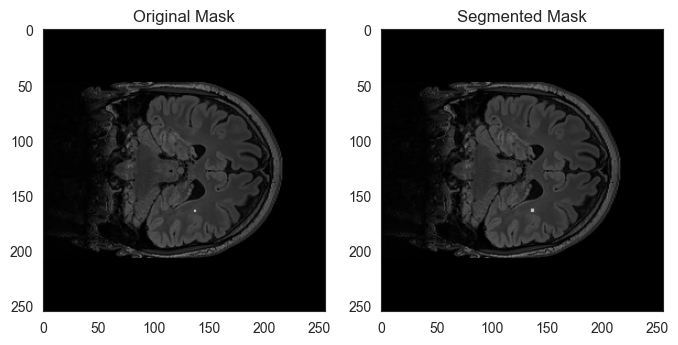

Computation Time: 7.110383033752441
Best Parameters: {'connectivity': 4, 'threshold': 100}
Average Score: 0.04462593280363737
Best Score: 0.6153846153846154


In [56]:
# Region Growing
params = {
    "connectivity": [4, 8],
    "threshold": [0.0001, 0.001, 0.05, 0.1, 1, 3, 5, 10, 20.5, 30, 60, 100, 150]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="RG", eval_score="DSC", axis="coronal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

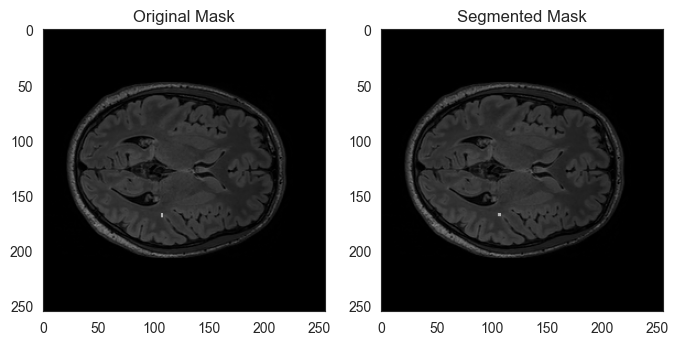

Computation Time: 6.86309289932251
Best Parameters: {'connectivity': 4, 'threshold': 100}
Average Score: 0.046409597354619025
Best Score: 0.7058823529411765


In [57]:
# Region Growing
params = {
    "connectivity": [4, 8],
    "threshold": [0.0001, 0.001, 0.05, 0.1, 1, 3, 5, 10, 20.5, 30, 60, 100, 150]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="RG", eval_score="DSC", axis="transverse")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

Flooding

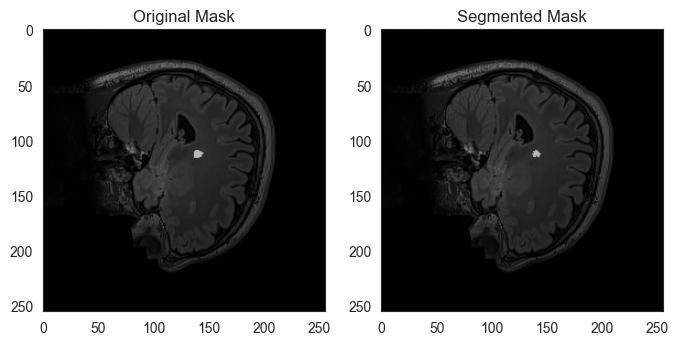

Computation Time: 6.60408878326416
Best Parameters: {'connectivity': 4, 'tolerance': 10}
Average Score: 0.0780333032780985
Best Score: 0.7848101265822784


In [58]:
# Flooding
params = {
    "connectivity": [4, 8],
    "tolerance": [0.1, 1, 3, 5, 10, 22, 30, 50, 100]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="FL", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}") 
print(f"Best Score: {best_score}")

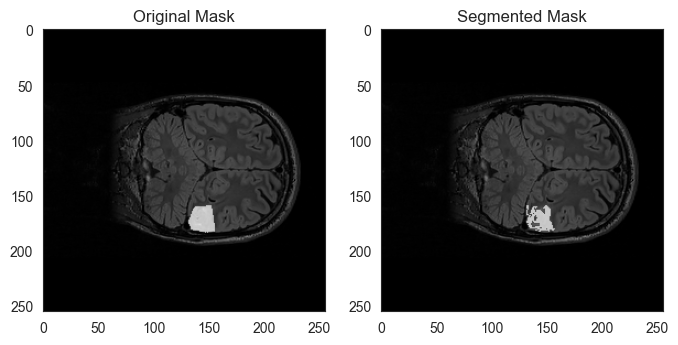

Computation Time: 6.774839878082275
Best Parameters: {'connectivity': 4, 'tolerance': 10}
Average Score: 0.12121718456675948
Best Score: 0.8211284513805522


In [50]:
# Flooding
params = {
    "connectivity": [4, 8],
    "tolerance": [0.1, 1, 3, 5, 10, 22, 30, 50, 100]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="FL", eval_score="DSC", axis="coronal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}") 
print(f"Best Score: {best_score}")

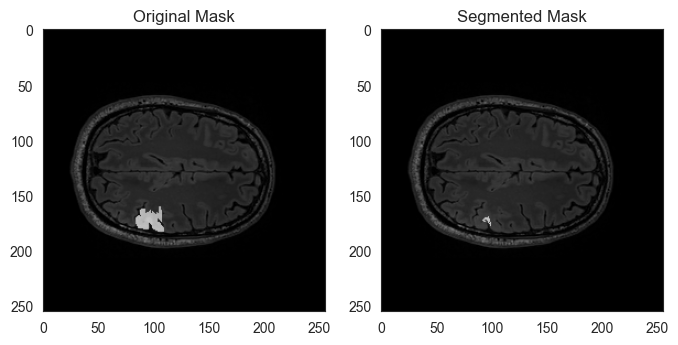

Computation Time: 5.675246477127075
Best Parameters: {'connectivity': 4, 'tolerance': 10}
Average Score: 0.06535287909472137
Best Score: 0.5293132328308208


In [62]:
# Flooding
params = {
    "connectivity": [4, 8],
    "tolerance": [0.1, 1, 3, 5, 10, 22, 30, 50, 100]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="FL", eval_score="DSC", axis="transverse")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}") 
print(f"Best Score: {best_score}")

Fuzzy C-Means

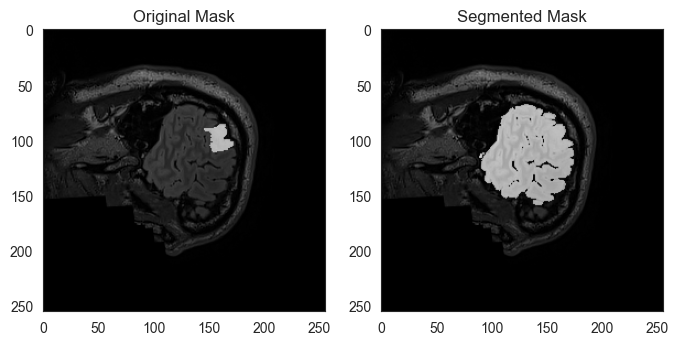

Computation Time: 692.5075500011444
Best Parameters: {'n_clusters': 2, 'm': 1, 'error': 0.0001, 'maxiter': 100}
Average Score: 0.029839450967068908
Best Score: 0.13722004976892996


In [69]:
# Fuzzy C-Means
params = {
    "n_clusters": [2, 6],
    "m": [1, 4, 6],
    "error": [0.0001, 0.001],
    "maxiter": [100, 500]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="FCM", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

Felzenszwalb

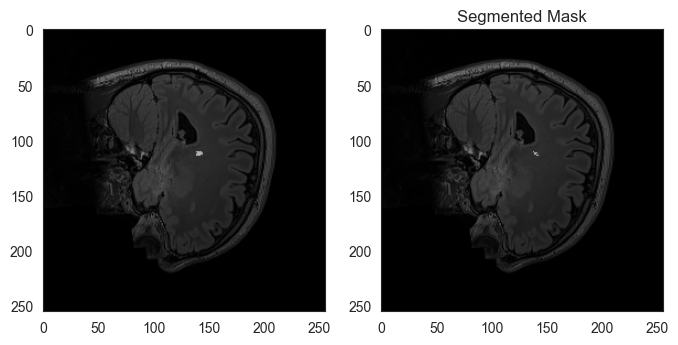

Computation Time: 687.3492522239685
Best Parameters: {'scale': 25, 'sigma': 0.001, 'min_size': 2}
Average Score: 0.02599967846630076
Best Score: 0.42857142857142855


In [66]:
# Felzenszwalb
params = {
    "scale": [25, 50, 100, 200],
    "sigma": [0.001, 0.5],
    "min_size": [2, 4, 8]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="Felzenszwalb", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

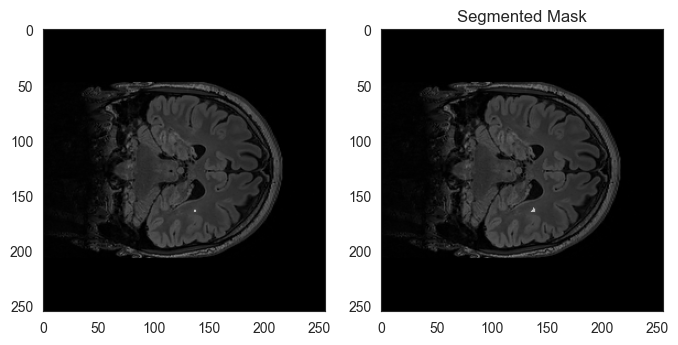

Computation Time: 447.3073720932007
Best Parameters: {'scale': 25, 'sigma': 0.001, 'min_size': 2}
Average Score: 0.058238283819262875
Best Score: 0.5714285714285714


In [67]:
# Felzenszwalb
params = {
    "scale": [25, 50, 100, 200],
    "sigma": [0.001, 0.5],
    "min_size": [2, 4, 8]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="Felzenszwalb", eval_score="DSC", axis="coronal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

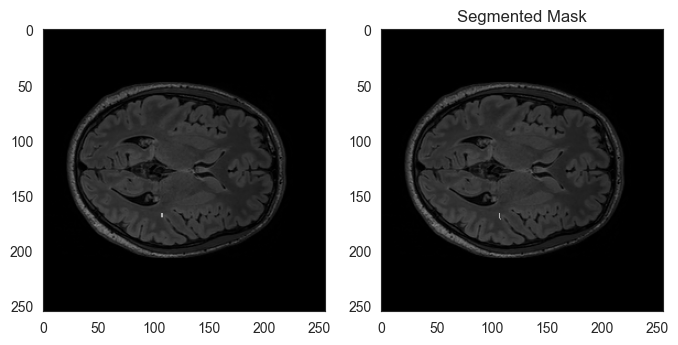

Computation Time: 459.51739025115967
Best Parameters: {'scale': 25, 'sigma': 0.001, 'min_size': 2}
Average Score: 0.035477447156479575
Best Score: 0.5714285714285714


In [68]:
# Felzenszwalb
params = {
    "scale": [25, 50, 100, 200],
    "sigma": [0.001, 0.5],
    "min_size": [2, 4, 8]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="Felzenszwalb", eval_score="DSC", axis="transverse")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

SLIC

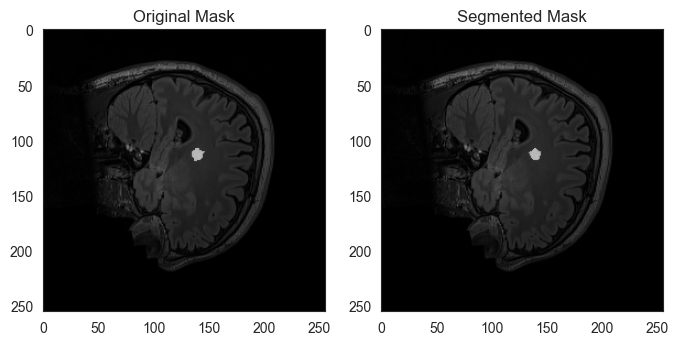

Computation Time: 705.342538356781
Best Parameters: {'n_segments': 500, 'compactness': 0.07, 'sigma': 0.1}
Average Score: 0.03478964177942754
Best Score: 0.9142857142857143


In [70]:
# SLIC
params = {
    "n_segments": [50, 100, 250, 500],
    "compactness": [0.01, 0.07, 0.4, 1],
    "sigma": [0.1, 1, 1.5]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="SLIC", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

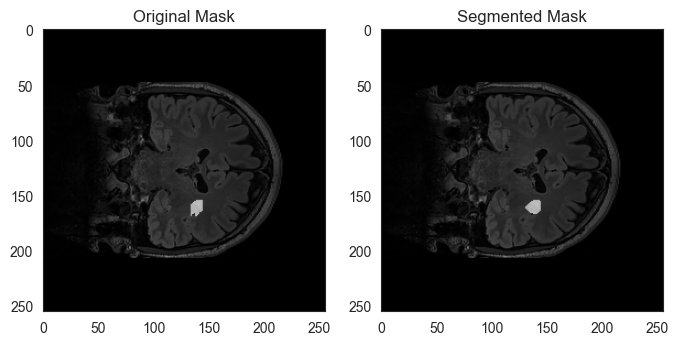

Computation Time: 183.41578817367554
Best Parameters: {'n_segments': 500, 'compactness': 0.07, 'sigma': 1.5}
Average Score: 0.16848108384431798
Best Score: 0.8913857677902621


In [63]:
# SLIC
params = {
    "n_segments": [50, 100, 250, 500],
    "compactness": [0.01, 0.07, 0.4, 1],
    "sigma": [0.1, 1, 1.5]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="SLIC", eval_score="DSC", axis="coronal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

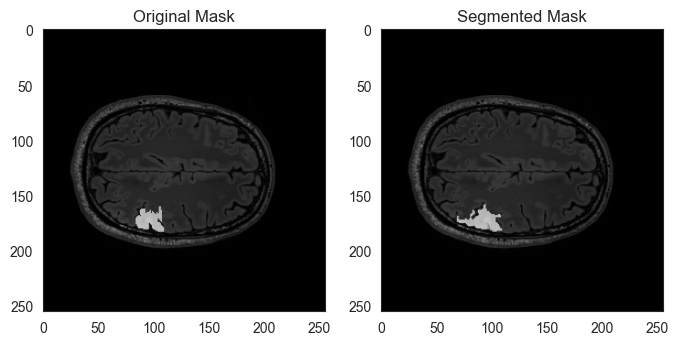

Computation Time: 178.71119356155396
Best Parameters: {'n_segments': 250, 'compactness': 0.07, 'sigma': 1}
Average Score: 0.09678853993679391
Best Score: 0.7647058823529411


In [64]:
# SLIC
params = {
    "n_segments": [50, 100, 250, 500],
    "compactness": [0.01, 0.07, 0.4, 1],
    "sigma": [0.1, 1, 1.5]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="SLIC", eval_score="DSC", axis="transverse")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

# Convolutional Neural Network

### Pre-processing

In [ ]:
try:
    sagittal_balance = sagittal_balance
    coronal_balance = coronal_balance
    transverse_balance = transverse_balance
except:
    sagittal_balance = 0.192
    coronal_balance = 0.105
    transverse_balance = 0.093

print(f"Sagittal Balance: {sagittal_balance}")
print(f"Coronal Balance: {coronal_balance}")
print(f"Transverse Balance: {transverse_balance}")


In [41]:
def split_data(images, label_images, test_size=0.3, val_size=0.66, random_state=42):
    # Shuffling data
    images, label_images = shuffle(images, label_images, random_state=random_state)

    # Split data into training and a combined validation/test set
    train_images, val_test_images, train_labels, val_test_labels = train_test_split(
        images, label_images, test_size=test_size, random_state=random_state)

    # Further split the combined validation/test set into separate validation and test sets
    val_images, test_images, val_labels, test_labels = train_test_split(
        val_test_images, val_test_labels, test_size=val_size, random_state=random_state)

    return train_images, val_images, test_images, train_labels, val_labels, test_labels

sag_train_images, sag_val_images, sag_test_images, sag_train_labels, sag_val_labels, sag_test_labels = split_data(sag_images, sag_label_images)
del sag_images, sag_label_images

cor_train_images, cor_val_images, cor_test_images, cor_train_labels, cor_val_labels, cor_test_labels = split_data(cor_images, cor_label_images)
del cor_images, cor_label_images

tra_train_images, tra_val_images, tra_test_images, tra_train_labels, tra_val_labels, tra_test_labels = split_data(tra_images, tra_label_images)
del tra_images, tra_label_images

(2847, 256, 256) (2847, 256, 256)
(2847, 256, 256, 1) (2847, 256, 256, 1)


In [93]:
# reshape data
print("Sagittal Plane")
sag_train_images = np.array(sag_train_images)
sag_train_labels = np.array(sag_train_labels)
sag_val_images = np.array(sag_val_images)
sag_val_labels = np.array(sag_val_labels)
sag_test_images = np.array(sag_test_images)
sag_test_labels = np.array(sag_test_labels) 
print(sag_train_images.shape, sag_train_labels.shape)

sag_train_images = sag_train_images.reshape((-1, 256, 256, 1))  # Reshape to include the channel dimension
sag_train_labels = sag_train_labels.reshape((-1, 256, 256, 1))  # Do the same for labels
sag_val_images = sag_val_images.reshape((-1, 256, 256, 1))
sag_val_labels = sag_val_labels.reshape((-1, 256, 256, 1))
sag_test_images = sag_test_images.reshape((-1, 256, 256, 1))
sag_test_labels = sag_test_labels.reshape((-1, 256, 256, 1))
print(sag_train_images.shape, sag_train_labels.shape)

print("Coronal Plane")
cor_train_images = np.array(cor_train_images)
cor_train_labels = np.array(cor_train_labels)
cor_val_images = np.array(cor_val_images)
cor_val_labels = np.array(cor_val_labels)
cor_test_images = np.array(cor_test_images)
cor_test_labels = np.array(cor_test_labels)
print(cor_train_images.shape, cor_train_labels.shape)

cor_train_images = cor_train_images.reshape((-1, 256, 256, 1))  # Reshape to include the channel dimension
cor_train_labels = cor_train_labels.reshape((-1, 256, 256, 1))  # Do the same for labels
cor_val_images = cor_val_images.reshape((-1, 256, 256, 1))
cor_val_labels = cor_val_labels.reshape((-1, 256, 256, 1))
cor_test_images = cor_test_images.reshape((-1, 256, 256, 1))
cor_test_labels = cor_test_labels.reshape((-1, 256, 256, 1))
print(cor_train_images.shape, cor_train_labels.shape)

print("Transverse Plane")
tra_train_images = np.array(tra_train_images)
tra_train_labels = np.array(tra_train_labels)
tra_val_images = np.array(tra_val_images)
tra_val_labels = np.array(tra_val_labels)
tra_test_images = np.array(tra_test_images)
tra_test_labels = np.array(tra_test_labels)
print(tra_train_images.shape, tra_train_labels.shape)

tra_train_images = tra_train_images.reshape((-1, 256, 256, 1))  # Reshape to include the channel dimension
tra_train_labels = tra_train_labels.reshape((-1, 256, 256, 1))  # Do the same for labels
tra_val_images = tra_val_images.reshape((-1, 256, 256, 1))
tra_val_labels = tra_val_labels.reshape((-1, 256, 256, 1))
tra_test_images = tra_test_images.reshape((-1, 256, 256, 1))
tra_test_labels = tra_test_labels.reshape((-1, 256, 256, 1))
print(tra_train_images.shape, tra_train_labels.shape)

Sagittal Plane
(2847, 256, 256, 1) (2847, 256, 256, 1)
(2847, 256, 256, 1) (2847, 256, 256, 1)
Coronal Plane
(3950, 256, 256) (3950, 256, 256)
(3950, 256, 256, 1) (3950, 256, 256, 1)
Transverse Plane
(3855, 256, 256) (3855, 256, 256)
(3855, 256, 256, 1) (3855, 256, 256, 1)


### Simple Model

In [42]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(1024, (3, 3), activation="relu", padding="same"),

    UpSampling2D((2, 2)),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    Conv2D(1, (1, 1), activation="sigmoid")
])

# Compile the model
model.compile(optimizer=Adam(),
            loss="binary_crossentropy",
            metrics=[MeanIoU(num_classes=2)])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

Sagittal

In [128]:
history = model.fit(np.array(sag_train_images).reshape(-1, 256, 256, 1), 
          np.array(sag_train_labels).reshape(-1, 256, 256, 1), 
          epochs=5, batch_size=32, 
          validation_data=(np.array(sag_val_images).reshape(-1, 256, 256, 1), 
                           np.array(sag_val_labels).reshape(-1, 256, 256, 1)))

Epoch 1/5
89/89 [==============================] - 117s 1s/step - loss: 0.0061 - mean_io_u: 0.2500 - val_loss: 0.0051 - val_mean_io_u: 0.2500
Epoch 2/5
89/89 [==============================] - 216s 2s/step - loss: 0.0035 - mean_io_u: 0.2500 - val_loss: 0.0058 - val_mean_io_u: 0.2500
Epoch 3/5
89/89 [==============================] - 213s 2s/step - loss: 0.0035 - mean_io_u: 0.2500 - val_loss: 0.0032 - val_mean_io_u: 0.2500
Epoch 4/5
89/89 [==============================] - 207s 2s/step - loss: 0.0023 - mean_io_u: 0.2500 - val_loss: 0.0026 - val_mean_io_u: 0.2500
Epoch 5/5
89/89 [==============================] - 214s 2s/step - loss: 0.0020 - mean_io_u: 0.2500 - val_loss: 0.0025 - val_mean_io_u: 0.2500


In [129]:
score = model.evaluate(np.array(sag_test_images).reshape(-1, 256, 256, 1))
print(f"Test Score: {score}")

30/30 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mean_io_u: 0.0000e+00
Test Score: [0.0, 0.0]


In [130]:
model.save("weights/CNN-Sagittal.h5")

In [89]:
predicted_masks = []

for i in range(len(sag_test_images)):
    test_mask = model.predict(sag_test_images[i].reshape(-1, 256, 256, 1), verbose=0)
    percent_mask = test_mask > np.percentile(test_mask, 99.5)
    percent_mask = percent_mask.astype(int).reshape(256, 256, 1)
    predicted_masks.append(percent_mask)

eval_print_scores(np.array(sag_test_labels).reshape(-1, 256, 256), np.array(predicted_masks).reshape(-1, 256, 256))

labels_flat = sag_test_labels.flatten()
predicted_masks_flat = np.array(predicted_masks).flatten()

Dice Score:  0.13177078209542548
Sensitivity Score:  0.2810192178583417
Specificity Score:  0.9954188305464416
Average Hausdorff Distance:  133.06389442670013


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00  62098336
         1.0       0.10      0.07      0.08     95328

    accuracy                           1.00  62193664
   macro avg       0.55      0.53      0.54  62193664
weighted avg       1.00      1.00      1.00  62193664



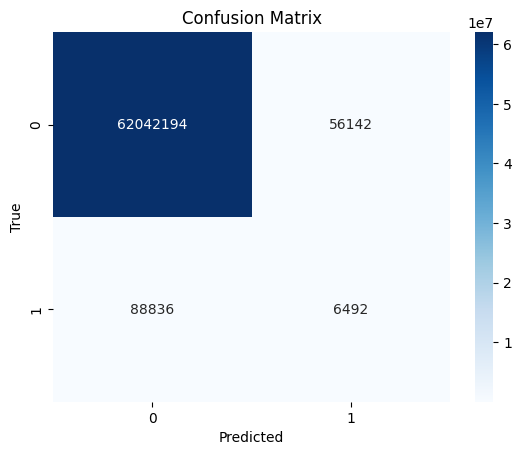

In [47]:
print(classification_report(labels_flat, predicted_masks_flat))

cm = confusion_matrix(labels_flat, predicted_masks_flat)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 18ms/step


(1, 256, 256, 1)
0.4762845849802372


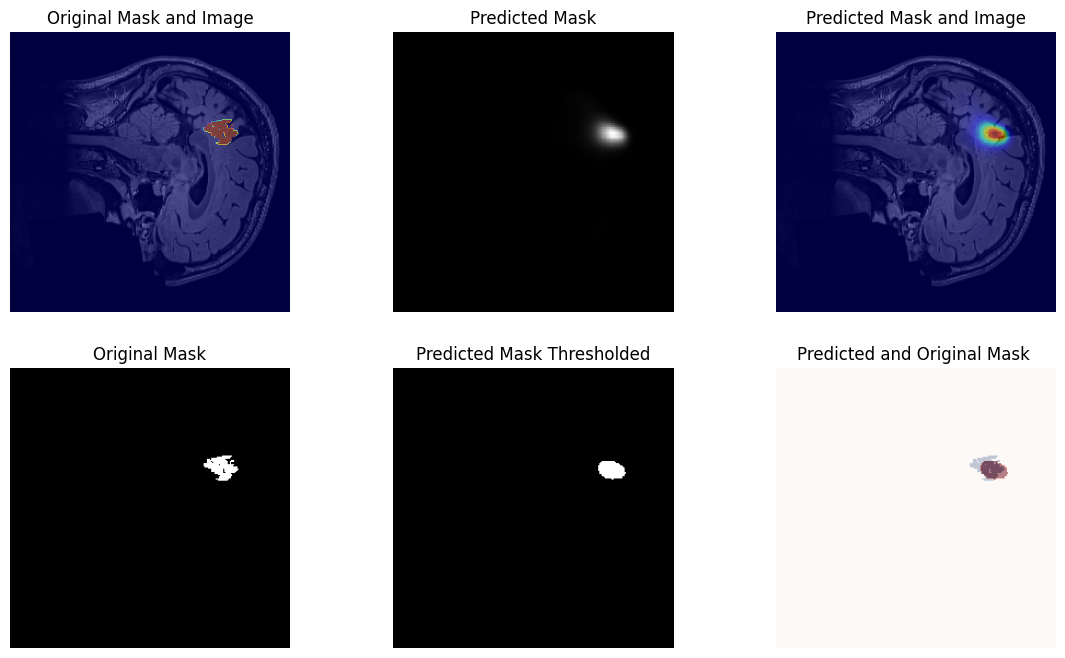

In [74]:
i = 312 # using sagittal axis and 20 subjects
test = sag_test_images[i].reshape(-1, 256, 256, 1)

# print(test.shape)
# print(np.max(test))

predicted_mask = model.predict(test)
print(predicted_mask.shape)
test_mask = predicted_mask.reshape(256, 256)

# print(test_mask)
# print(np.max(test_mask))

test_mask_mean = np.mean(test_mask)
mean_mask = test_mask > test_mask_mean
percent_mask = test_mask > np.percentile(test_mask, 99.5)
percent_mask = percent_mask.astype(int).reshape(256, 256, 1)

# print(percent_mask)
# print(np.max(percent_mask))
# print(np.min(percent_mask))
# print(np.max(sag_train_labels[i].astype(int)))
# print(np.min(sag_train_labels[i].astype(int)))
# print(percent_mask.shape)
# print((sag_train_labels[i].astype(int)).shape)

print(evaluate(sag_test_labels[i].astype(int), percent_mask, metric="IoU"))

plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(sag_test_images[i], cmap='gray')
plt.imshow(sag_test_labels[i], cmap='jet', alpha=0.5)
plt.title("Original Mask and Image"), plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(test_mask, cmap='gray')
plt.title("Predicted Mask"), plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(sag_test_images[i], cmap='gray')
plt.imshow(test_mask, cmap='jet', alpha=0.5) 
plt.title("Predicted Mask and Image"), plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(sag_test_labels[i], cmap='gray')
plt.title("Original Mask"), plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(percent_mask, cmap='gray')
plt.title("Predicted Mask Thresholded"), plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(sag_test_labels[i], cmap='Blues', alpha=0.5)
plt.imshow(percent_mask, cmap='Reds',alpha=0.5)
plt.title("Predicted and Original Mask "), plt.axis("off")

plt.show()

Coronal

In [90]:
history = model.fit(np.array(cor_train_images).reshape(-1, 256, 256, 1), 
          np.array(cor_train_labels).reshape(-1, 256, 256, 1), 
          epochs=5, batch_size=32, 
          validation_data=(np.array(cor_val_images).reshape(-1, 256, 256, 1), 
                           np.array(cor_val_labels).reshape(-1, 256, 256, 1)))

Epoch 1/5
124/124 [==============================] - 132s 1s/step - loss: 0.0048 - mean_io_u: 0.2500 - val_loss: 0.0050 - val_mean_io_u: 0.2530
Epoch 2/5
124/124 [==============================] - 180s 1s/step - loss: 0.0035 - mean_io_u: 0.2500 - val_loss: 0.0034 - val_mean_io_u: 0.2530
Epoch 3/5
124/124 [==============================] - 180s 1s/step - loss: 0.0026 - mean_io_u: 0.2500 - val_loss: 0.0028 - val_mean_io_u: 0.2530
Epoch 4/5
124/124 [==============================] - 194s 2s/step - loss: 0.0022 - mean_io_u: 0.2500 - val_loss: 0.0028 - val_mean_io_u: 0.2530
Epoch 5/5
124/124 [==============================] - 188s 2s/step - loss: 0.0018 - mean_io_u: 0.2500 - val_loss: 0.0023 - val_mean_io_u: 0.2530


In [91]:
score = model.evaluate(np.array(cor_test_images).reshape(-1, 256, 256, 1))
print(f"Test Score: {score}")

42/42 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mean_io_u: 0.0000e+00
Test Score: [0.0, 0.0]


In [119]:
model.save("weights/CNN-Coronal.h5")

In [94]:
predicted_masks = []

for i in range(len(cor_test_images)):
    test_mask = model.predict(cor_test_images[i].reshape(-1, 256, 256, 1), verbose=0)
    percent_mask = test_mask > np.percentile(test_mask, 99.5)
    percent_mask = percent_mask.astype(int).reshape(256, 256, 1)
    predicted_masks.append(percent_mask)

eval_print_scores(np.array(cor_test_labels).reshape(-1, 256, 256), np.array(predicted_masks).reshape(-1, 256, 256))

labels_flat = cor_test_labels.flatten()
predicted_masks_flat = np.array(predicted_masks).flatten()

Dice Score:  0.20100783767258118
Sensitivity Score:  0.5843204992477852
Specificity Score:  0.9955980419984293
Average Hausdorff Distance:  145.29280780547947


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00  86221177
         1.0       0.12      0.58      0.20     89735

    accuracy                           1.00  86310912
   macro avg       0.56      0.79      0.60  86310912
weighted avg       1.00      1.00      1.00  86310912



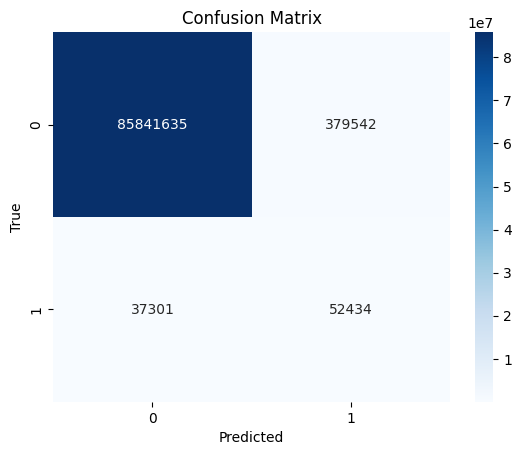

In [95]:
print(classification_report(labels_flat, predicted_masks_flat))

cm = confusion_matrix(labels_flat, predicted_masks_flat)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 20ms/step


(1, 256, 256, 1)
0.6306068601583114


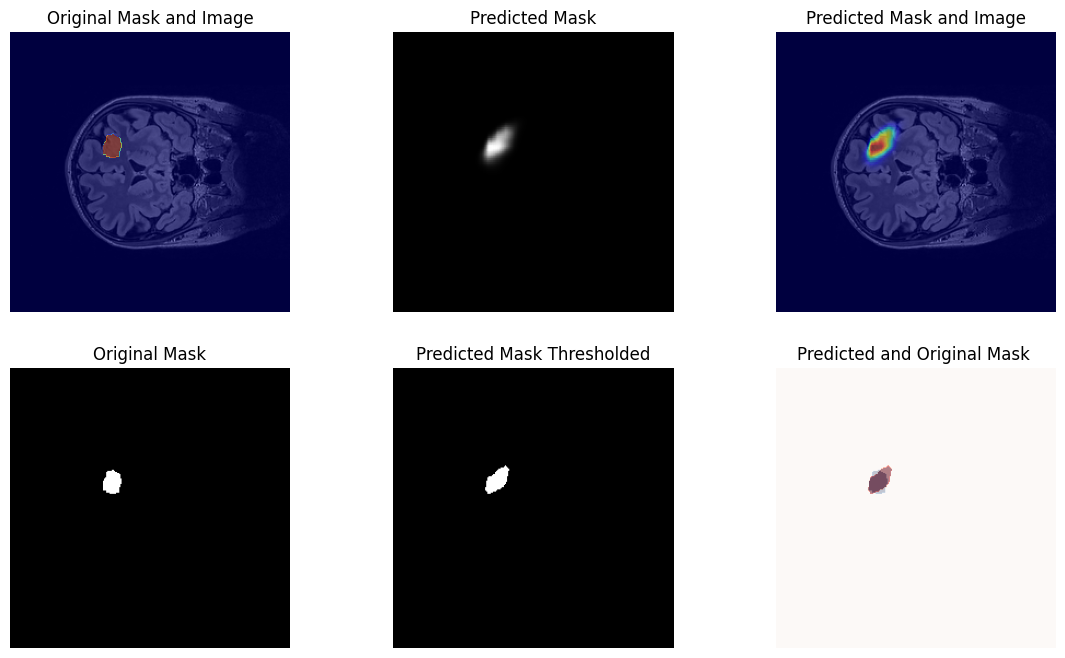

In [118]:
i = 433 # using coronal axis and 20 subjects
test = cor_test_images[i].reshape(-1, 256, 256, 1)

# i = 321 # using transverse axis and 20 subjects
# test = sag_test_images[i].reshape(-1, 256, 256, 1)

# print(test.shape)
# print(np.max(test))

predicted_mask = model.predict(test)
print(predicted_mask.shape)
test_mask = predicted_mask.reshape(256, 256)

# print(test_mask)
# print(np.max(test_mask))

test_mask_mean = np.mean(test_mask)
mean_mask = test_mask > test_mask_mean
percent_mask = test_mask > np.percentile(test_mask, 99.5)
percent_mask = percent_mask.astype(int).reshape(256, 256, 1)

# print(percent_mask)
# print(np.max(percent_mask))
# print(np.min(percent_mask))
# print(np.max(sag_train_labels[i].astype(int)))
# print(np.min(sag_train_labels[i].astype(int)))
# print(percent_mask.shape)
# print((sag_train_labels[i].astype(int)).shape)

print(evaluate(cor_test_labels[i].astype(int), percent_mask, metric="IoU"))

plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(cor_test_images[i], cmap='gray')
plt.imshow(cor_test_labels[i], cmap='jet', alpha=0.5)
plt.title("Original Mask and Image"), plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(test_mask, cmap='gray')
plt.title("Predicted Mask"), plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(cor_test_images[i], cmap='gray')
plt.imshow(test_mask, cmap='jet', alpha=0.5) 
plt.title("Predicted Mask and Image"), plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(cor_test_labels[i], cmap='gray')
plt.title("Original Mask"), plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(percent_mask, cmap='gray')
plt.title("Predicted Mask Thresholded"), plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(cor_test_labels[i], cmap='Blues', alpha=0.5)
plt.imshow(percent_mask, cmap='Reds',alpha=0.5)
plt.title("Predicted and Original Mask "), plt.axis("off")

plt.show()

Transverse

In [121]:
history = model.fit(np.array(tra_train_images).reshape(-1, 256, 256, 1), 
          np.array(tra_train_labels).reshape(-1, 256, 256, 1), 
          epochs=5, batch_size=32, 
          validation_data=(np.array(tra_val_images).reshape(-1, 256, 256, 1), 
                           np.array(tra_val_labels).reshape(-1, 256, 256, 1)))

Epoch 1/5
121/121 [==============================] - 168s 1s/step - loss: 0.0054 - mean_io_u: 0.2500 - val_loss: 0.0039 - val_mean_io_u: 0.2531
Epoch 2/5
121/121 [==============================] - 80s 663ms/step - loss: 0.0034 - mean_io_u: 0.2500 - val_loss: 0.0027 - val_mean_io_u: 0.2531
Epoch 3/5
121/121 [==============================] - 81s 668ms/step - loss: 0.0024 - mean_io_u: 0.2500 - val_loss: 0.0023 - val_mean_io_u: 0.2531
Epoch 4/5
121/121 [==============================] - 82s 683ms/step - loss: 0.0020 - mean_io_u: 0.2500 - val_loss: 0.0019 - val_mean_io_u: 0.2531
Epoch 5/5
121/121 [==============================] - 81s 671ms/step - loss: 0.0018 - mean_io_u: 0.2500 - val_loss: 0.0018 - val_mean_io_u: 0.2531


In [122]:
score = model.evaluate(np.array(tra_test_images).reshape(-1, 256, 256, 1))
print(f"Test Score: {score}")

41/41 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mean_io_u: 0.0000e+00
Test Score: [0.0, 0.0]


In [123]:
model.save("weights/CNN-Transverse.h5")

In [124]:
predicted_masks = []

for i in range(len(tra_test_images)):
    test_mask = model.predict(tra_test_images[i].reshape(-1, 256, 256, 1), verbose=0)
    percent_mask = test_mask > np.percentile(test_mask, 99.5)
    percent_mask = percent_mask.astype(int).reshape(256, 256, 1)
    predicted_masks.append(percent_mask)

eval_print_scores(np.array(tra_test_labels).reshape(-1, 256, 256), np.array(predicted_masks).reshape(-1, 256, 256))

labels_flat = tra_test_labels.flatten()
predicted_masks_flat = np.array(predicted_masks).flatten()

Dice Score:  0.17308563130445645
Sensitivity Score:  0.48801400017610286
Specificity Score:  0.995516785773349
Average Hausdorff Distance:  141.73566946961517


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00  84122904
         1.0       0.11      0.49      0.17     90856

    accuracy                           0.99  84213760
   macro avg       0.55      0.74      0.59  84213760
weighted avg       1.00      0.99      1.00  84213760



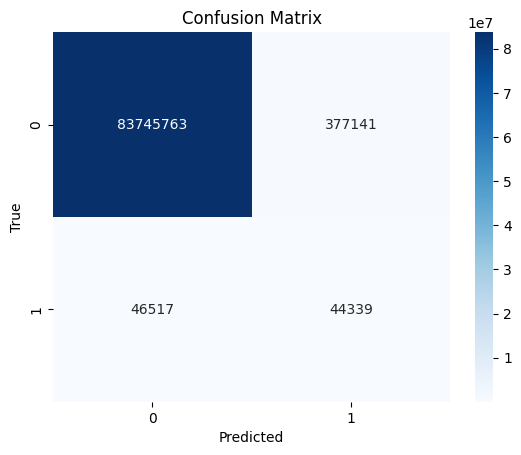

In [125]:
print(classification_report(labels_flat, predicted_masks_flat))

cm = confusion_matrix(labels_flat, predicted_masks_flat)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 21ms/step


(1, 256, 256, 1)
0.6741573033707865


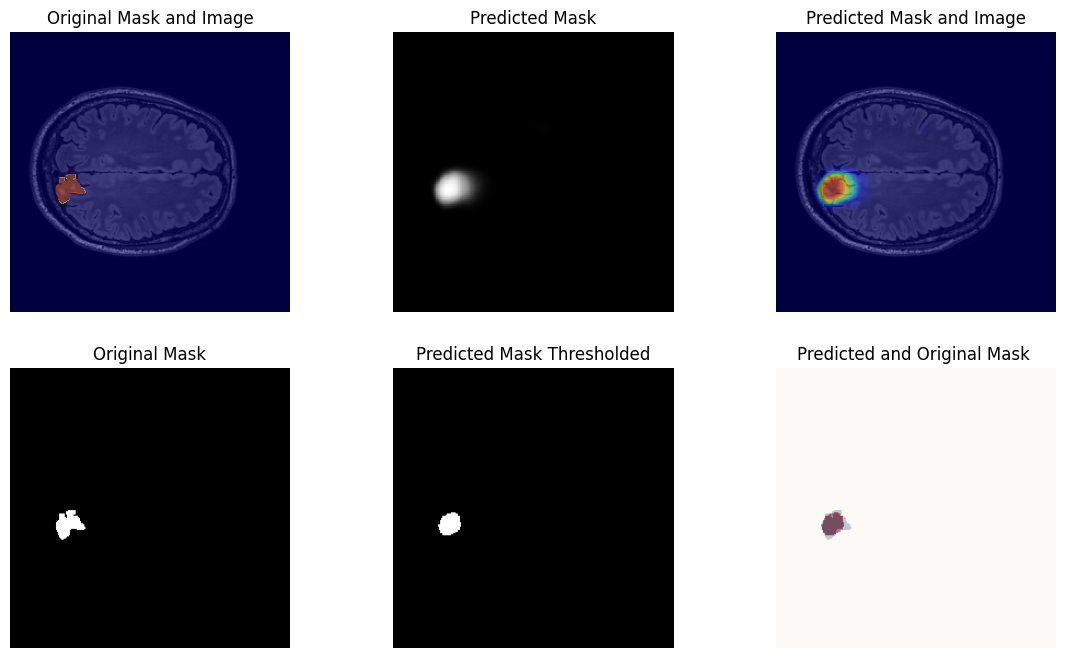

In [127]:
i = 23 # using transverse axis and 20 subjects
test = tra_test_images[i].reshape(-1, 256, 256, 1)

# print(test.shape)
# print(np.max(test))

predicted_mask = model.predict(test)
print(predicted_mask.shape)
test_mask = predicted_mask.reshape(256, 256)

# print(test_mask)
# print(np.max(test_mask))

test_mask_mean = np.mean(test_mask)
mean_mask = test_mask > test_mask_mean
percent_mask = test_mask > np.percentile(test_mask, 99.5)
percent_mask = percent_mask.astype(int).reshape(256, 256, 1)

# print(percent_mask)
# print(np.max(percent_mask))
# print(np.min(percent_mask))
# print(np.max(sag_train_labels[i].astype(int)))
# print(np.min(sag_train_labels[i].astype(int)))
# print(percent_mask.shape)
# print((sag_train_labels[i].astype(int)).shape)

print(evaluate(tra_test_labels[i].astype(int), percent_mask, metric="IoU"))

plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(tra_test_images[i], cmap='gray')
plt.imshow(tra_test_labels[i], cmap='jet', alpha=0.5)
plt.title("Original Mask and Image"), plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(test_mask, cmap='gray')
plt.title("Predicted Mask"), plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(tra_test_images[i], cmap='gray')
plt.imshow(test_mask, cmap='jet', alpha=0.5) 
plt.title("Predicted Mask and Image"), plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(tra_test_labels[i], cmap='gray')
plt.title("Original Mask"), plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(percent_mask, cmap='gray')
plt.title("Predicted Mask Thresholded"), plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(tra_test_labels[i], cmap='Blues', alpha=0.5)
plt.imshow(percent_mask, cmap='Reds',alpha=0.5)
plt.title("Predicted and Original Mask "), plt.axis("off")

plt.show()

### U-Net

#### ResNet50

In [ ]:
def expand_grayscale_to_rgb(x):
    # Replicate the grayscale channel to create an RGB-like tensor
    x = tf.keras.backend.repeat_elements(x, 3, axis=-1)
    return x

def encoder(input_shape):
    # Define a custom input layer that accepts grayscale images
    inputs = Input(shape=input_shape)

    # Expand the grayscale images to 3 channels
    x = Lambda(expand_grayscale_to_rgb)(inputs)

    # Load ResNet50 with weights pre-trained on ImageNet
    encoder = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=x)

    # Define layers for skip connections
    skip_connection_layers = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out']
    encoder_outputs = [encoder.get_layer(name).output for name in skip_connection_layers]

    return inputs, encoder_outputs

def decoder(encoder_outputs):
    # Start from the last output of the encoder
    x = encoder_outputs[-1]  # Last layer of encoder

    # Define the number of filters in each convolutional block
    num_filters = [256, 128, 64, 32]

    # Add Upsampling, Concatenation and Conv2D layers
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        if i < len(encoder_outputs) - 1:  # Check if skip connection is available
            x = concatenate([x, encoder_outputs[-(i + 2)]])  # Skip connection
        x = Conv2D(f, (3, 3), activation='relu', padding='same')(x)
    return x

def unet(input_shape):
    inputs, encoder_outputs = encoder(input_shape)
    x = decoder(encoder_outputs)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Assuming binary segmentation

    model = Model(inputs, outputs)
    return model

input_shape = (256, 256, 1)  # Example input shape, adjust as needed
unet_model = unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
unet_model.fit(sag_train_images, sag_train_labels, epochs=5, validation_data=(sag_val_images, sag_val_labels))


#### VGG16

In [23]:
def expand_grayscale_to_rgb(x):
    # Replicate the grayscale channel to create an RGB-like tensor
    x = tf.keras.backend.repeat_elements(x, 3, axis=-1)
    return x

def encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Lambda(expand_grayscale_to_rgb)(inputs)

    # Load VGG16 (or another VGG variant) with weights pre-trained on ImageNet
    encoder = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=x)

    # Define layers for skip connections (after each pooling layer)
    skip_connection_layers = ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool']
    encoder_outputs = [encoder.get_layer(name).output for name in skip_connection_layers]

    return inputs, encoder_outputs

def decoder(encoder_outputs):
    # Start from the last output of the encoder
    x = encoder_outputs[-1]  # Last layer of encoder

    # Define the number of filters in each convolutional block
    num_filters = [512, 256, 128, 64]

    # Add Upsampling, Concatenation and Conv2D layers
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        if i < len(encoder_outputs) - 1:  # Check if skip connection is available
            x = concatenate([x, encoder_outputs[-(i + 2)]])  # Skip connection
        x = Conv2D(f, (3, 3), activation='relu', padding='same')(x)
    return x

def unet(input_shape):
    inputs, encoder_outputs = encoder(input_shape)
    x = decoder(encoder_outputs)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Assuming binary segmentation

    model = Model(inputs, outputs)
    return model

input_shape = (256, 256, 1)  # Example input shape, adjust as needed
unet_model = unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
unet_model.fit(sag_train_images, sag_train_labels, epochs=5, validation_data=(sag_val_images, sag_val_labels))


Epoch 1/5
60/60 [==============================] - 1015s 17s/step - loss: 2.8301 - accuracy: 0.9824 - val_loss: 0.1801 - val_accuracy: 0.9994
Epoch 2/5
60/60 [==============================] - 951s 16s/step - loss: 0.0493 - accuracy: 0.9988 - val_loss: 0.0145 - val_accuracy: 0.9994
Epoch 3/5
60/60 [==============================] - 884s 15s/step - loss: 0.0250 - accuracy: 0.9992 - val_loss: 0.0402 - val_accuracy: 0.9994
Epoch 4/5
60/60 [==============================] - 1029s 17s/step - loss: 0.0188 - accuracy: 0.9994 - val_loss: 0.0135 - val_accuracy: 0.9994
Epoch 5/5
60/60 [==============================] - 1206s 20s/step - loss: 0.0099 - accuracy: 0.9993 - val_loss: 0.0497 - val_accuracy: 0.9994


In [24]:
test_IoU = unet_model.evaluate(np.array(sag_test_images).reshape(-1, 256, 256, 1))
print(f"Test IoU: {test_IoU}")

20/20 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test IoU: [0.0, 0.0]


#### Segmentation Plot

(1, 256, 256, 1)
371.9968870729208
1/1 [==============================] - 0s 21ms/step


(1, 256, 256, 1)


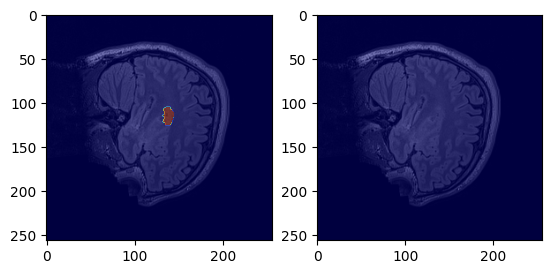

In [32]:
image = 115
test = sag_images[image].reshape(-1, 256, 256, 1)
print(test.shape)
print(np.max(test))

predicted_mask = unet_model.predict(test)
print(predicted_mask.shape)
test_mask = predicted_mask.reshape(256, 256)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(sag_images[image], cmap='gray')
plt.imshow(sag_label_images[image], cmap='jet', alpha=0.5)

plt.subplot(1, 2, 2)
plt.imshow(sag_images[image], cmap='gray')
plt.imshow(test_mask, cmap='jet', alpha=0.5) 
plt.show()

# Out-Of-Sample Prediction

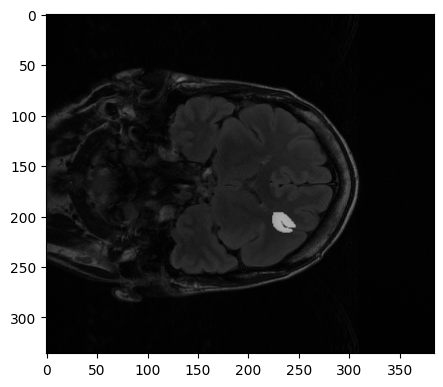

In [159]:
# Load OOS data
current_directory = os.getcwd()
data_directory = current_directory + r"\Datasets\ds004199"

t2_vol = nib.load(data_directory + "/sub-00018/anat/sub-00018_acq-corhipp4mm_FLAIR.nii.gz")
t2roi_vol = nib.load(data_directory + "/sub-00018/anat/sub-00018_acq-corhipp4mm_FLAIR_roi.nii.gz")

t2_data = t2_vol.get_fdata()
t2roi_data = t2roi_vol.get_fdata()

i = 12

plt.figure(figsize=(5, 5))
plt.imshow(t2_data[:, :, i], cmap='gray')
plt.imshow(t2roi_data[:, :, i], cmap='gray', alpha=0.5)
plt.show()


In [376]:
# Data Load

# File pattern
pattern = "*mm_FLAIR.nii.gz"
pattern_label = "*mm_FLAIR_roi.nii.gz"

t2_2d_flair_images = []
t2_2d_flair_label_images = []

for folder in os.listdir(data_directory):
    if "sub" in folder:
        sub_folder = data_directory + "/" + folder + "/anat"
        # print(f"Sub-folder: {sub_folder}")
        # print(f"Files in sub-folder: {os.listdir(sub_folder)}")

        # Get a list of file paths that match the pattern
        file_paths = glob.glob(os.path.join(sub_folder, pattern))
        if file_paths:
            # print(file_paths)
            # Load the image from file
            t2vol = nib.load(file_paths[0])
            # Get the image data as a numpy array
            t2data = t2vol.get_fdata()
            # append to list
            t2_2d_flair_images.append(t2data)
            
for folder in os.listdir(data_directory):
    if "sub" in folder:
        sub_folder = data_directory + "/" + folder + "/anat"
        # print(f"Sub-folder: {sub_folder}")
        # print(f"Files in sub-folder: {os.listdir(sub_folder)}")

        # Get a list of file paths that match the pattern
        file_paths = glob.glob(os.path.join(sub_folder, pattern_label))
        if file_paths:
            # print(file_paths)
            # Load the image from file
            t2vol = nib.load(file_paths[0])
            # Get the image data as a numpy array
            t2data = t2vol.get_fdata()
            # append to list
            t2_2d_flair_label_images.append(t2data)

# print(f"Number of images found: {len(t2_2d_flair_images)}")
# print(f"Number of labels found: {len(t2_2d_flair_label_images)}")

cor_images = []
cor_labels = []

for i in range(len(t2_2d_flair_images)):
    for j in range(t2_2d_flair_images[i].shape[2]):
        cor_images.append(t2_2d_flair_images[i][:, :, j])
        cor_labels.append(t2_2d_flair_label_images[i][:, :, j])

print(f"Number of coronal images: {len(cor_images)}")
print(f"Number of coronal labels: {len(cor_labels)}")

Number of coronal images: 184
Number of coronal labels: 184


Shape of transverse images: (336, 384)
Shape of scaled transverse images: (256, 256)


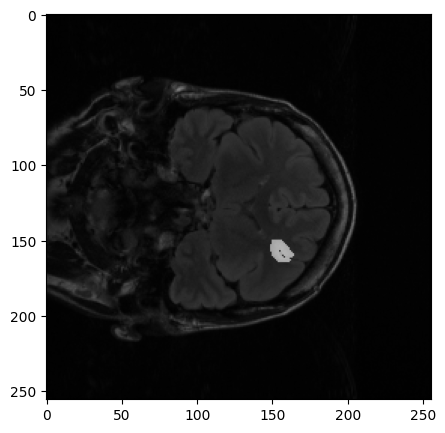

In [377]:
print(f"Shape of transverse images: {cor_images[0].shape}")

# Scale images and labels to 256x256
scaled_cor_images = [resize(image, (256, 256)) for image in cor_images]
scaled_cor_labels = [resize(label, (256, 256)) for label in cor_labels]

cor_images = scaled_cor_images
cor_labels = scaled_cor_labels

# for image in tra_images:
#     print(f"Image shape: {image.shape}")

# Verify the shape of the scaled images
print(f"Shape of scaled transverse images: {scaled_cor_images[0].shape}")

cor_labels = [np.where(label > 0.5, 1, 0) for label in cor_labels]

plt.figure(figsize=(5, 5))
plt.imshow(cor_images[12], cmap='gray')
plt.imshow(cor_labels[12], cmap='gray', alpha=0.5)
plt.show()

SLIC

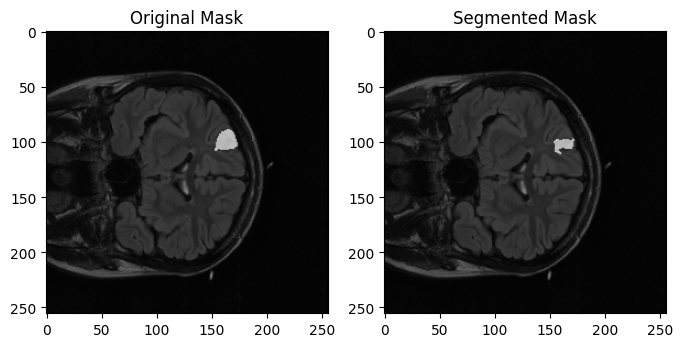

Computation Time: 92.80478930473328
Best Parameters: {'n_segments': 500, 'compactness': 0.07, 'sigma': 1.5}
Average Score: 0.057328970148834715
Best Score: 0.6405228758169934


In [378]:
# SLIC
cor_pos_images = []
cor_pos_masks = []

for i in range(len(cor_labels)):
    if np.any(cor_labels[i] > 0):
        cor_pos_images.append(cor_images[i])
        cor_pos_masks.append(cor_labels[i])

params = {
    "n_segments": [50, 100, 250, 500],
    "compactness": [0.01, 0.07, 0.4, 1],
    "sigma": [0.1, 1, 1.5]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="SLIC", eval_score="DSC", axis="coronal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

In [ ]:
scores = []
for n, image in enumerate(cor_pos_images):
    mask = slic(image, cor_pos_masks[n], seed_points=find_seeds(cor_pos_masks[n]), param=best_params)
    plt.imshow(image, cmap="gray"), plt.imshow(mask, cmap="jet", alpha=0.5), plt.axis("off"), plt.title(f"SLIC on Image {n}"), plt.show()
    eval_print_scores(cor_pos_masks[n], mask)

    time.sleep(0.3)
    clear_output(wait=True)
    
    scores.append(evaluate(cor_pos_masks[n], mask, metric="DSC"))

# print(f"Max DSC Score: {np.max(scores)}")

Dice Score:  0.8825910931174089
Sensitivity Score:  0.9478260869565217
Specificity Score:  0.9996484309319638
Average Hausdorff Distance:  2.0


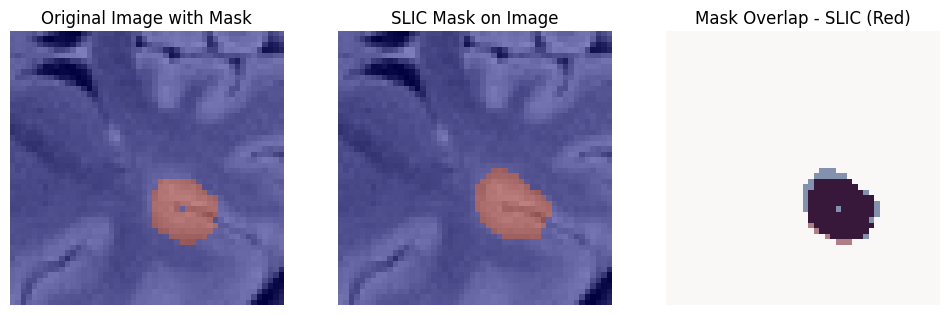

In [394]:
n = 4

mask = slic(image, cor_pos_masks[n], seed_points=find_seeds(cor_pos_masks[n]), param=best_params)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image[125:175,125:175], cmap="gray"), plt.imshow(cor_pos_masks[4][125:175,125:175], cmap="jet", alpha=0.5), plt.axis("off"), plt.title(f"Original Image with Mask")
plt.subplot(1, 3, 2)
plt.imshow(image[125:175,125:175], cmap="gray"), plt.imshow(mask[125:175,125:175], cmap="jet", alpha=0.5), plt.axis("off"), plt.title(f"SLIC Mask on Image")
plt.subplot(1, 3, 3)
plt.imshow(mask[125:175,125:175], cmap="Blues"), plt.imshow(cor_pos_masks[n][125:175,125:175], cmap="Reds", alpha=0.5), plt.axis("off"), plt.title(f"Mask Overlap - SLIC (Red)")

eval_print_scores(cor_pos_masks[n], mask)

Coronal Model

In [241]:
# Load Model
model = tf.keras.models.load_model("weights/CNN-Coronal.h5")

In [262]:
predicted_masks = []

for i in range(len(cor_images)):
    test_mask = model.predict(np.array(cor_images[i]).reshape(-1, 256, 256, 1), verbose=0)
    percent_mask = test_mask > np.percentile(test_mask, 99.5)
    percent_mask = percent_mask.astype(int).reshape(256, 256, 1)
    predicted_masks.append(percent_mask)

eval_print_scores(np.array(cor_labels).reshape(-1, 256, 256) > 0.5, np.array(predicted_masks).reshape(-1, 256, 256))

labels_flat = np.array(cor_labels).flatten() > 0.5
predicted_masks_flat = np.array(predicted_masks).flatten() > 0.5

Dice Score:  0.009316816704363327
Sensitivity Score:  0.04852551100015603
Specificity Score:  0.9950182601289472
Average Hausdorff Distance:  179.9638852659055


              precision    recall  f1-score   support

       False       1.00      1.00      1.00  12052215
        True       0.01      0.05      0.01      6409

    accuracy                           0.99  12058624
   macro avg       0.50      0.52      0.50  12058624
weighted avg       1.00      0.99      1.00  12058624



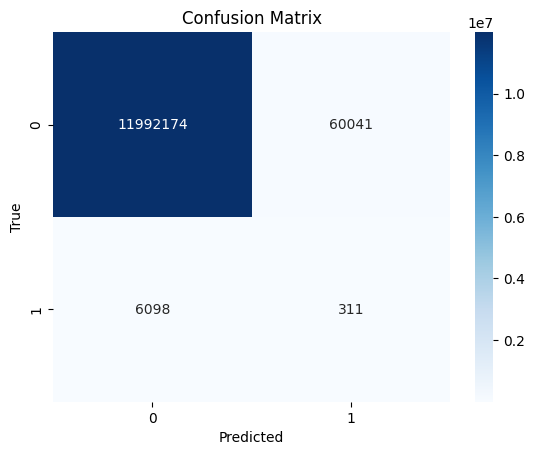

In [263]:
print(classification_report(labels_flat, predicted_masks_flat))

cm = confusion_matrix(labels_flat, predicted_masks_flat)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 23ms/step
IoU Score:  0.13217768147345613


(Text(0.5, 1.0, 'Predicted and Original Mask '), (-0.5, 255.5, 255.5, -0.5))

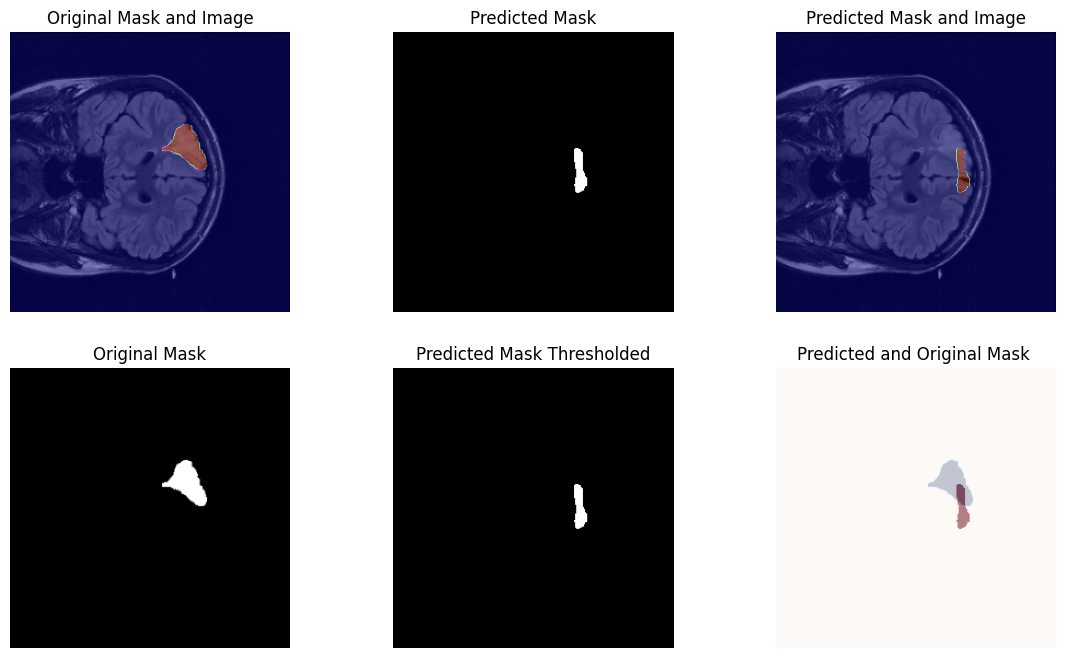

In [267]:
i = 154 # using transverse axis and 20 subjects
test = cor_images[i].reshape(-1, 256, 256, 1)

# print(test.shape)
# print(np.max(test))

predicted_mask = model.predict(test)
# print(predicted_mask.shape)
# print(predicted_mask.min())
test_mask = np.where(predicted_mask.reshape(256, 256) > np.percentile(predicted_mask, 99.5), 1, 0)

# print(test_mask)
# print(np.max(test_mask))

test_mask_mean = np.mean(test_mask)
mean_mask = test_mask > test_mask_mean
percent_mask = test_mask
percent_mask = percent_mask.astype(int).reshape(256, 256, 1)

# print(percent_mask)
# print(np.max(percent_mask))
# print(np.min(percent_mask))
# print(np.max(sag_train_labels[i].astype(int)))
# print(np.min(sag_train_labels[i].astype(int)))
# print(percent_mask.shape)
# print((sag_train_labels[i].astype(int)).shape)

# for i in range(len(cor_labels)):
#     test = cor_images[i].reshape(-1, 256, 256, 1)
#     predicted_mask = model.predict(test)
#     test_mask = np.where(predicted_mask.reshape(256, 256) > np.percentile(predicted_mask, 99.5), 1, 0)

#     score = evaluate(cor_labels[i].astype(int), test_mask, metric="IoU")
#     print(f"Image: {i}, IoU: {score}")

print("IoU Score: ", evaluate(cor_labels[i].astype(int), test_mask, metric="IoU"))

plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(cor_images[i], cmap='gray')
plt.imshow(cor_labels[i], cmap='jet', alpha=0.5)
plt.title("Original Mask and Image"), plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(test_mask, cmap='gray')
plt.title("Predicted Mask"), plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(cor_images[i], cmap='gray')
plt.imshow(test_mask, cmap='jet', alpha=0.5) 
plt.title("Predicted Mask and Image"), plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(cor_labels[i], cmap='gray')
plt.title("Original Mask"), plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(percent_mask, cmap='gray')
plt.title("Predicted Mask Thresholded"), plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(cor_labels[i], cmap='Blues', alpha=0.5)
plt.imshow(percent_mask, cmap='Reds',alpha=0.5)
plt.title("Predicted and Original Mask "), plt.axis("off")

# plt.show()